In [58]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Analyzing the trained model

In [59]:
# import os; os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".99"

In [60]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from typing import Any, Callable, Sequence, Union
import numpy as np

import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')

import jax
from jax import lax, random, numpy as jnp
from flax.core import freeze, unfreeze, FrozenDict
from flax import linen as nn
from flax import struct
from flax.training import train_state
from flax.training import orbax_utils

import optax
import orbax.checkpoint

from clu import metrics
from ml_collections import ConfigDict

from einops import reduce, rearrange
import wandb
from iqadatasets.datasets import *
from fxlayers.layers import *
from fxlayers.layers import GaussianLayerGamma, GaborLayerLogSigma_
from fxlayers.initializers import *
from JaxPlayground.utils.constraints import *
from JaxPlayground.utils.wandb import *

In [61]:
# jax.config.update("jax_debug_nans", False)

## Generate the stimuli

We will be generating an image with a given background frequency and a given stimuli frequency.

In [62]:
import matplotlib.pyplot as plt

In [63]:
IMG_SHAPE = (384,512,3)

In [64]:
def control_lum_contrast(image, L, C):
    # CONTROL_LUM_CONTRAST sets the average luminance and RMSE sinus-like contrast for a natural image 
    img_mean = jnp.mean(image)
    img_std = jnp.std(image)*jnp.sqrt(2)
    if img_std == 0:
        img_std = 1
    new_image = (image - img_mean)/img_std
    new_image = L + C*L*new_image
    return new_image

In [65]:
def generate_sinusoid(img_size, freq, theta, phase, fs, lum=None, contrast=None, normalize_energy=False, zero_mean=False):
    def sinusoid(x, y, freq, theta, phase, normalize_energy=False, zero_mean=False):        
        ## Obtain the normalization coeficient
        g = jnp.cos(2*jnp.pi*freq*(x*jnp.cos(theta)+y*jnp.sin(theta)) + phase)
        g = jnp.where(zero_mean, g - g.mean(), g)
        E_norm = jnp.where(normalize_energy, jnp.sqrt(jnp.sum(g**2)), 1.)
        return g/E_norm
    x, y = jnp.meshgrid(jnp.linspace(0,img_size[1]/fs,num=img_size[1]), jnp.linspace(0,img_size[0]/fs,num=img_size[0]))
    sin = sinusoid(x-img_size[0]/fs/2, y-img_size[1]/fs/2, freq, theta, phase, normalize_energy, zero_mean)
    if (lum is None) and (contrast is None): return sin
    elif (lum is not None) and (contrast is None): return control_lum_contrast(sin, L=lum, C=sin.std())
    elif (lum is None) and (contrast is not None): return control_lum_contrast(sin, L=sin.mean(), C=contrast)
    else: return control_lum_contrast(sin, L=lum, C=contrast)

In [66]:
def get_range(arr): return arr.min(), arr.max()

(Array(-0.19745556, dtype=float32), Array(0.19279072, dtype=float32))


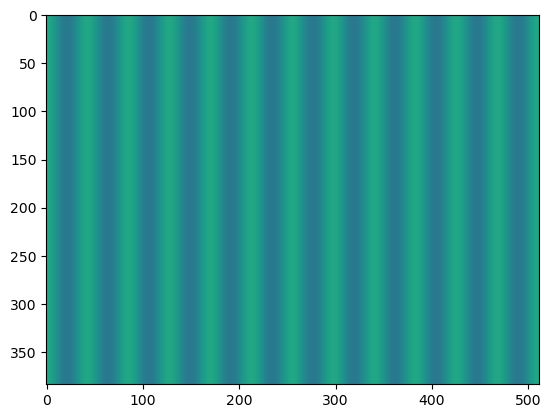

In [67]:
# background = generate_sinusoid((384,384), freq=3, theta=0, phase=0, fs=128)
background = generate_sinusoid(IMG_SHAPE, freq=3, theta=0, phase=0, fs=128, lum=None, contrast=100)
plt.imshow(background, vmin=-1, vmax=1)
print(get_range(background))
plt.show()

The first step will be generating noise of a given frequency for the background. The easiest way to acomplish that is through the Fourier Transform:

In [68]:
import cmath
from perceptualtests.utils import spatio_temp_freq_domain

In [69]:
def noise(fx2,# Frequency space x dominion.
          fy2, # Frequency space y dominion.
          fm, # Minimum frequency.
          fM, # Maximum frequency.
          angle, # Angle of rotation in Fourier.
          delta_a, # Width taken in Fourier.
          seed=random.PRNGKey(42), # Random seed
          ):

    a_m = -delta_a/2
    a_M = delta_a/2

    f = jnp.sqrt(fx2**2+fy2**2)
    a = 180*jnp.arctan2(fy2,fx2)/jnp.pi

    F_noise_f = 1*((f>fm) & (f<fM))
    F_noise_a = 1*(((a>a_m+angle) & (a<a_M+angle)) | ((a>a_m+angle+180) & (a<a_M+angle+180)) | ((a>a_m+angle-180) & (a<a_M+angle-180)) )   

    F_noise = F_noise_f*F_noise_a

    nf = F_noise*jnp.exp(cmath.sqrt(-1)*(2*jnp.pi*random.uniform(seed, shape=(fx2.shape[0], fx2.shape[1]))))
    nx = jnp.fft.ifft2(jnp.fft.ifftshift(nf)).real

    return nx, nf, F_noise  

In [70]:
# fig, axes = plt.subplots(1,3, figsize=(16,4))
# axes[0].imshow(nx)
# axes[1].imshow(nf.real)
# axes[2].imshow(F_noise)
# plt.show()

In [71]:
def generate_noise_freq(IMG_SHAPE, fm, fM, angle, delta_a, fs, lum=None, contrast=None, seed=random.PRNGKey(42)):
    x, y, _, ffx, ffy, _ = spatio_temp_freq_domain(*IMG_SHAPE[:-1], 1, fs/2, fs/2, 1)
    nx, nf, F_noise = noise(ffx, ffy, fm=fm, fM=fM, angle=angle, delta_a=delta_a, seed=seed)
    if (lum is None) and (contrast is None): return nx
    elif (lum is not None) and (contrast is None): return control_lum_contrast(nx, L=lum, C=nx.std())
    elif (lum is None) and (contrast is not None): return control_lum_contrast(nx, L=nx.mean(), C=contrast)
    else: return control_lum_contrast(nx, L=lum, C=contrast)

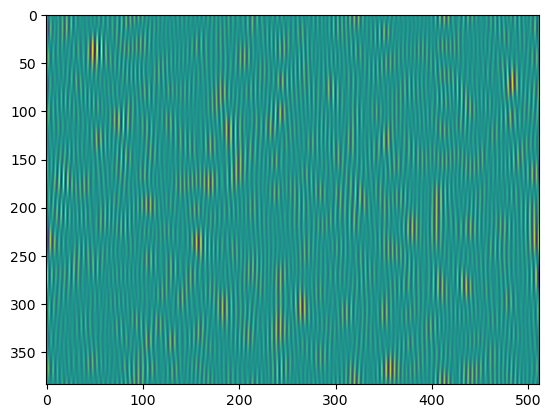

In [72]:
noise_freq = generate_noise_freq(IMG_SHAPE, fm=12, fM=16, angle=0, delta_a=10, fs=128)
plt.imshow(noise_freq)
plt.show()

Now that we have both the sinusoid and the controlled-frequency noise, we can put them together to build the final stimuli to be used:

In [73]:
## Background config ##
fm = 12
fM = 16
angle = 0
delta_a = 10
fs = 128
lum_bg, contrast_bg = 50, 10

## Sinusoid config ##
freq = 3
theta = 0
phase = 0
fs = 128
lum_s, contrast_s = 50, 10

background = generate_noise_freq(IMG_SHAPE, fm=fm, fM=fM, angle=angle, delta_a=delta_a, fs=fs, lum=lum_bg, contrast=contrast_bg)
sinusoid = generate_sinusoid(jnp.array(IMG_SHAPE)//4, freq=3, theta=0, phase=0, fs=128, lum=lum_s, contrast=contrast_s)

In [74]:
background.shape, sinusoid.shape

((384, 512), (96, 128))

In [75]:
def insert_image(img1, img2):
    """Inserts img2 at the middle of img1."""
    h1, w1 = img1.shape
    h2, w2 = img2.shape
    return img1.at[h1//2-h2//2:h1//2+h2//2, w1//2-w2//2:w1//2+w2//2].set(img2)

In [76]:
def insert_image_addition(img1, img2):
    """Inserts img2 at the middle of img1."""
    h1, w1 = img1.shape
    h2, w2 = img2.shape
    return img1.at[h1//2-h2//2:h1//2+h2//2, w1//2-w2//2:w1//2+w2//2].set(img1[h1//2-h2//2:h1//2+h2//2, w1//2-w2//2:w1//2+w2//2] + img2)

In [77]:
def adjust_range(arr): return (arr-arr.min())/(arr.max()-arr.min())

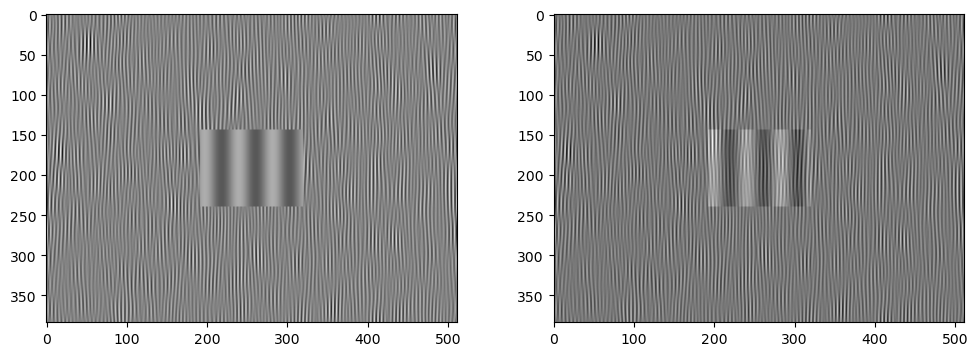

In [78]:
l = insert_image(background, sinusoid)
l = adjust_range(l)
k = insert_image_addition(background, sinusoid)
k = adjust_range(k)
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].imshow(l, cmap="gray")
axes[1].imshow(k, cmap="gray")
plt.show()

In [79]:
config = {
    "BATCH_SIZE": 64,
    "EPOCHS": 500,
    "LEARNING_RATE": 8e-3,
    "SEED": 42,
    "GDN_CLIPPING": True,
    "NORMALIZE_PROB": False,
    "NORMALIZE_ENERGY": True,
    "ZERO_MEAN": True,
    "USE_BIAS": False,
    "N_SCALES": 4,
    "N_ORIENTATIONS": 8,
}
config = ConfigDict(config)
config

BATCH_SIZE: 64
EPOCHS: 500
GDN_CLIPPING: true
LEARNING_RATE: 0.008
NORMALIZE_ENERGY: true
NORMALIZE_PROB: false
N_ORIENTATIONS: 8
N_SCALES: 4
SEED: 42
USE_BIAS: false
ZERO_MEAN: true

In [80]:
wandb.init(project="PerceptNet_JaX",
           name="V2_Init",
           job_type="training",
           config=config,
           mode="disabled",
           )
config = config
config

BATCH_SIZE: 64
EPOCHS: 500
GDN_CLIPPING: true
LEARNING_RATE: 0.008
NORMALIZE_ENERGY: true
NORMALIZE_PROB: false
N_ORIENTATIONS: 8
N_SCALES: 4
SEED: 42
USE_BIAS: false
ZERO_MEAN: true

In [81]:
# id = "w7o5ilfk" # LR = 3e-3
id = "4t8vdwbp" # No A / No Alphas

In [82]:
api = wandb.Api()
prev_run = api.run(f"jorgvt/PerceptNet_JaX/{id}")

In [83]:
config = ConfigDict(prev_run.config["_fields"])

In [84]:
for file in prev_run.files():
    file.download(root=prev_run.dir, replace=True)

## Define the model we're going to use

> It's going to be a very simple model just for demonstration purposes.

In [85]:
#| export
class GDNGaussianStarRunning(nn.Module):
    """GDN variation where x^* is obtained as a running mean of the previously obtained values."""

    kernel_size: int
    inputs_star: float = 1.
    outputs_star: Union[None, float] = None
    fs: int = 1
    apply_independently: bool = False
    alpha: float = 2.
    epsilon: float = 1/2
    bias_init: Callable = nn.initializers.ones_init()

    @nn.compact
    def __call__(self,
                 inputs,
                 train=False,
                 **kwargs,
                 ):
        # inputs_sign = jnp.sign(inputs)
        # inputs = jnp.abs(inputs)
        is_initialized = self.has_variable("batch_stats", "inputs_star")
        # inputs_star = self.variable("batch_stats", "inputs_star", lambda x: x, jnp.quantile(inputs, q=0.95))
        inputs_star = self.variable("batch_stats", "inputs_star", lambda x: jnp.ones(x)*self.inputs_star, (1,))
        if is_initialized and train:
            inputs_star.value = (inputs_star.value + jnp.quantile(jnp.abs(inputs), q=0.95))/2
        H = GaussianLayerGamma(features=inputs.shape[-1], kernel_size=self.kernel_size, use_bias=True, fs=self.fs, xmean=self.kernel_size/self.fs/2, ymean=self.kernel_size/self.fs/2, bias_init=self.bias_init, normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY)
        inputs_star_ = jnp.ones_like(inputs)*inputs_star.value
        denom = jnp.clip(H(inputs**self.alpha, train=train), a_min=1e-5)**self.epsilon
        coef = (jnp.clip(H(inputs_star_**self.alpha, train=train), a_min=1e-5)**self.epsilon)#/inputs_star_
        if self.outputs_star is not None: coef = coef/inputs_star.value*self.outputs_star
        
        return coef*inputs/denom

In [86]:
class GDNSpatioFreqOrient(nn.Module):
    """Generalized Divisive Normalization."""
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    inputs_star: float = 1.
    outputs_star: Union[None, float] = None
    fs: int = 1
    apply_independently: bool = False
    bias_init: Callable = nn.initializers.ones_init()
    alpha: float = 2.
    epsilon: float = 1/2 # Exponential of the denominator
    eps: float = 1e-6 # Numerical stability in the denominator

    @nn.compact
    def __call__(self,
                 inputs,
                 fmean,
                 theta_mean,
                 train=False,
                 ):
        b, h, w, c = inputs.shape
        bias = self.param("bias",
                          #equal_to(inputs_star/10),
                          self.bias_init,
                          (c,))
        is_initialized = self.has_variable("batch_stats", "inputs_star")
        inputs_star = self.variable("batch_stats", "inputs_star", lambda x: jnp.ones(x)*self.inputs_star, (len(self.inputs_star),))
        inputs_star_ = jnp.ones_like(inputs)*inputs_star.value
        GL = GaussianLayerGamma(features=c, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding, fs=self.fs, xmean=self.kernel_size/self.fs/2, ymean=self.kernel_size/self.fs/2, normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, use_bias=False, feature_group_count=c)
        FG = FreqGaussian()
        OG = OrientGaussian()
        outputs = GL(inputs**self.alpha, train=train)#/(self.kernel_size**2)
        outputs = FG(outputs, fmean=fmean)
        ## Reshape so that the orientations are the innermost dimmension
        outputs = rearrange(outputs, "b h w (phase theta f) -> b h w (phase f theta)", b=b, h=h, w=w, phase=2, f=config.N_SCALES, theta=config.N_ORIENTATIONS)
        outputs = OG(outputs, theta_mean=theta_mean)
        ## Recover original disposition
        denom = rearrange(outputs, "b h w (phase f theta) -> b h w (phase theta f)", b=b, h=h, w=w, phase=2, f=config.N_SCALES, theta=config.N_ORIENTATIONS)

        ## Coef
        coef = GL(inputs_star_**self.alpha, train=train)#/(self.kernel_size**2)
        coef = FG(coef, fmean=fmean)
        coef = rearrange(coef, "b h w (phase theta f) -> b h w (phase f theta)", b=b, h=h, w=w, phase=2, f=config.N_SCALES, theta=config.N_ORIENTATIONS)
        coef = OG(coef, theta_mean=theta_mean) + bias
        coef = rearrange(coef, "b h w (phase f theta) -> b h w (phase theta f)", b=b, h=h, w=w, phase=2, f=config.N_SCALES, theta=config.N_ORIENTATIONS)
        coef = jnp.clip(coef+bias, a_min=1e-5)**self.epsilon
        # coef = inputs_star.value * coef
        if self.outputs_star is not None: coef = coef/inputs_star.value*self.outputs_star

        if is_initialized and train:
            inputs_star.value = (inputs_star.value + jnp.quantile(jnp.abs(inputs), q=0.95, axis=(0,1,2)))/2
        return coef * inputs / (jnp.clip(denom+bias, a_min=1e-5)**self.epsilon + self.eps)

In [87]:
from pickle import load
with open("gabor_x_star.pkl", "rb") as f:
    gabor_x_star = load(f)

In [88]:
class PerceptNet(nn.Module):
    """IQA model inspired by the visual system."""

    @nn.compact
    def __call__(self,
                 inputs, # Assuming fs = 128 (cpd)
                 **kwargs,
                 ):
        ## (Independent) Color equilibration (Gamma correction)
        ## bias = 0.1 / kernel = 0.5
        outputs = GDNStarSign(kernel_size=(1,1), apply_independently=True, inputs_star=1.)(inputs)
        
        ## ATD Transformation
        outputs = JamesonHurvich()(outputs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))
        
        ## GDN Star A - T - D [Separated]
        ### A
        outputs0 = GDNStarSign(kernel_size=(1,1), apply_independently=True, inputs_star=170.)(outputs[:,:,:,0:1])
        ### T
        outputs1 = GDNStarDisplacement(kernel_size=(1,1), apply_independently=True, inputs_star=55.)(outputs[:,:,:,1:2])
        outputs1 = outputs1*(2*55/170)
        ### D
        outputs2 = GDNStarDisplacement(kernel_size=(1,1), apply_independently=True, inputs_star=55.)(outputs[:,:,:,2:3])
        outputs2 = outputs2*(2*55/170)
        ### Put them back together
        outputs = jnp.concatenate([outputs0, outputs1, outputs2], axis=-1)

        ## Apply CSF on Fourier
        outputs = CSFFourier(fs=64, norm_energy=True)(outputs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))

        ## GDN per channel with mean substraction in T and D (Spatial Gaussian Kernel)
        ## TO-DO: - Spatial Gaussian Kernel (0.02 deg) -> fs = 64/2 & 0.02*64/2 = sigma (px) = 0.69
        ### A
        ### (384/4, 512/4, 1)
        ### fs = 32 / kernel_size = (11,11) -> 0.32 > 0.02 --> OK!
        outputs0 = GDNGaussianStarRunning(kernel_size=11, apply_independently=True, bias_init=equal_to([0.1]), inputs_star=0.3, outputs_star=None, fs=32)(outputs[:,:,:,0:1], **kwargs)
        ### T
        outputs1 = GDNGaussianStarRunning(kernel_size=11, apply_independently=True, bias_init=equal_to([0.01**2]), inputs_star=0.06, outputs_star=None, fs=32)(outputs[:,:,:,1:2], **kwargs)
        ### D
        outputs2 = GDNGaussianStarRunning(kernel_size=11, apply_independently=True, bias_init=equal_to([0.01**2]), inputs_star=0.08, outputs_star=None, fs=32)(outputs[:,:,:,2:3], **kwargs)
        ### Put them back together
        outputs = jnp.concatenate([outputs0, outputs1, outputs2], axis=-1)

        ## GaborLayer per channel with GDN mixing only same-origin-channel information
        ### A
        outputs0, fmean, theta_mean = GaborLayerLogSigma_(n_scales=config.N_SCALES, n_orientations=config.N_ORIENTATIONS, kernel_size=32, fs=32, strides=1, padding="SAME", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, zero_mean=config.ZERO_MEAN, use_bias=config.USE_BIAS)(outputs[:,:,:,0:1], return_freq=True, return_theta=True, **kwargs)
        ### [Gaussian] sigma = 0.2 (deg) fs = 32 / kernel_size = (21,21) -> 21/32 = 0.66 --> OK!
        outputs0 = GDNSpatioFreqOrient(kernel_size=21, strides=1, padding="SAME", fs=32, apply_independently=False, inputs_star=gabor_x_star["A"])(outputs0, fmean=fmean, theta_mean=theta_mean, **kwargs)
        ### T
        outputs1, fmean, theta_mean = GaborLayerLogSigma_(n_scales=config.N_SCALES, n_orientations=config.N_ORIENTATIONS, kernel_size=32, fs=32, strides=1, padding="SAME", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, zero_mean=config.ZERO_MEAN, use_bias=config.USE_BIAS)(outputs[:,:,:,1:2], return_freq=True, return_theta=True, **kwargs)
        ### [Gaussian] sigma = 0.2 (deg) fs = 32 / kernel_size = (21,21) -> 21/32 = 0.66 --> OK!
        outputs1 = GDNSpatioFreqOrient(kernel_size=21, strides=1, padding="SAME", fs=32, apply_independently=False, inputs_star=gabor_x_star["T"])(outputs1, fmean=fmean, theta_mean=theta_mean, **kwargs)
        ### D
        outputs2, fmean, theta_mean = GaborLayerLogSigma_(n_scales=config.N_SCALES, n_orientations=config.N_ORIENTATIONS, kernel_size=32, fs=32, strides=1, padding="SAME", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, zero_mean=config.ZERO_MEAN, use_bias=config.USE_BIAS)(outputs[:,:,:,2:3], return_freq=True, return_theta=True, **kwargs)
        ### [Gaussian] sigma = 0.2 (deg) fs = 32 / kernel_size = (21,21) -> 21/32 = 0.66 --> OK!
        outputs2 = GDNSpatioFreqOrient(kernel_size=21, strides=1, padding="SAME", fs=32, apply_independently=False, inputs_star=gabor_x_star["D"])(outputs2, fmean=fmean, theta_mean=theta_mean, **kwargs)

        ## Put them back together
        outputs = jnp.concatenate([outputs0, outputs1, outputs2], axis=-1)
        
        return outputs

## Define the metrics with `clu`

In [89]:
@struct.dataclass
class Metrics(metrics.Collection):
    """Collection of metrics to be tracked during training."""
    loss: metrics.Average.from_output("loss")

By default, `TrainState` doesn't include metrics, but it's very easy to subclass it so that it does:

In [90]:
class TrainState(train_state.TrainState):
    metrics: Metrics
    state: FrozenDict

We'll define a function that initializes the `TrainState` from a module, a rng key and some optimizer:

In [91]:
def create_train_state(module, key, tx, input_shape):
    """Creates the initial `TrainState`."""
    variables = module.init(key, jnp.ones(input_shape))
    state, params = variables.pop('params')
    return TrainState.create(
        apply_fn=module.apply,
        params=params,
        state=state,
        tx=tx,
        metrics=Metrics.empty()
    )

## Defining the training step

> We want to write a function that takes the `TrainState` and a batch of data can performs an optimization step.

In [92]:
def pearson_correlation(vec1, vec2):
    vec1 = vec1.squeeze()
    vec2 = vec2.squeeze()
    vec1_mean = vec1.mean()
    vec2_mean = vec2.mean()
    num = vec1-vec1_mean
    num *= vec2-vec2_mean
    num = num.sum()
    denom = jnp.sqrt(jnp.sum((vec1-vec1_mean)**2))
    denom *= jnp.sqrt(jnp.sum((vec2-vec2_mean)**2))
    return num/denom

In [93]:
@jax.jit
def train_step(state, batch):
    """Train for a single step."""
    img, img_dist, mos = batch
    def loss_fn(params):
        ## Forward pass through the model
        img_pred, updated_state = state.apply_fn({"params": params, **state.state}, img, mutable=list(state.state.keys()), train=True)
        img_dist_pred, updated_state = state.apply_fn({"params": params, **state.state}, img_dist, mutable=list(state.state.keys()), train=True)

        ## Calculate the distance
        dist = ((img_pred - img_dist_pred)**2).sum(axis=(1,2,3))**(1/2)
        
        ## Calculate pearson correlation
        return pearson_correlation(dist, mos), updated_state
    
    (loss, updated_state), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    metrics_updates = state.metrics.single_from_model_output(loss=loss)
    metrics = state.metrics.merge(metrics_updates)
    state = state.replace(metrics=metrics)
    state = state.replace(state=updated_state)
    return state

In their example, they don't calculate the metrics at the same time. I think it is kind of a waste because it means having to perform a new forward pass, but we'll follow as of now. Let's define a function to perform metric calculation:

In [94]:
@jax.jit
def compute_metrics(*, state, batch):
    """Obtaining the metrics for a given batch."""
    img, img_dist, mos = batch
    def loss_fn(params):
        ## Forward pass through the model
        img_pred, updated_state = state.apply_fn({"params": params, **state.state}, img, mutable=list(state.state.keys()), train=False)
        img_dist_pred, updated_state = state.apply_fn({"params": params, **state.state}, img_dist, mutable=list(state.state.keys()), train=False)

        ## Calculate the distance
        dist = ((img_pred - img_dist_pred)**2).sum(axis=(1,2,3))**(1/2)
        
        ## Calculate pearson correlation
        return pearson_correlation(dist, mos)
    
    metrics_updates = state.metrics.single_from_model_output(loss=loss_fn(state.params))
    metrics = state.metrics.merge(metrics_updates)
    state = state.replace(metrics=metrics)
    return state

## Loading the weights

In [95]:
state = create_train_state(PerceptNet(), random.PRNGKey(config.SEED), optax.adam(config.LEARNING_RATE), input_shape=(1,384,512,3))
state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))

In [96]:
import flax

In [97]:
def check_trainable(path):
    return ("A" in path) or ("alpha_achrom" in path) or ("alpha_chrom_rg" in path) or ("alpha_chrom_yb" in path)

In [98]:
trainable_tree = freeze(flax.traverse_util.path_aware_map(lambda path, v: "non_trainable" if check_trainable(path)  else "trainable", state.params))

In [99]:
optimizers = {
    "trainable": optax.adam(learning_rate=config.LEARNING_RATE),
    "non_trainable": optax.set_to_zero(),
}

In [100]:
tx = optax.multi_transform(optimizers, trainable_tree)

In [147]:
state = create_train_state(PerceptNet(), random.PRNGKey(config.SEED), tx, input_shape=(1,384,512,3))
state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))

In [ ]:
from einops import repeat

In [148]:
state.params["GaborLayerLogSigma__0"]

FrozenDict({
    freq: Array([12. ,  6. ,  3. ,  1.5], dtype=float32),
    logsigmax2: Array([-5.6629605, -4.276666 , -2.8903718, -1.5040774], dtype=float32),
    logsigmay2: Array([-4.5303683, -3.421333 , -2.3122976, -1.203262 ], dtype=float32),
    theta: Array([0.       , 0.3926991, 0.7853982, 1.1780972, 1.5707964, 1.9634955,
           2.3561945, 2.7488937], dtype=float32),
    sigma_theta: Array([0.       , 0.3926991, 0.7853982, 1.1780972, 1.5707964, 1.9634955,
           2.3561945, 2.7488937], dtype=float32),
})

In [149]:
l = GaborLayerLogSigma_(n_scales=config.N_SCALES, n_orientations=config.N_ORIENTATIONS, kernel_size=32, fs=32, strides=1, padding="SAME", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, zero_mean=config.ZERO_MEAN, use_bias=config.USE_BIAS)
x, y = l.generate_dominion()
kernel = jax.vmap(l.gabor, in_axes=(None,None,None,None,0,0,0,None,None,None,None,None,None,None), out_axes=0)
kernel = jax.vmap(kernel, in_axes=(None,None,None,None,None,None,None,0,0,None,None,None,None,None), out_axes=0)
kernel = jax.vmap(kernel, in_axes=(None,None,None,None,None,None,None,None,None,0,None,None,None,None), out_axes=0)(x, y, 
                                                                                                                    l.xmean, l.ymean, 
                                                                                                                    jnp.exp(state.params["GaborLayerLogSigma__0"]["logsigmax2"]), 
                                                                                                                    jnp.exp(state.params["GaborLayerLogSigma__0"]["logsigmay2"]), 
                                                                                                                    state.params["GaborLayerLogSigma__0"]["freq"],
                                                                                                                    state.params["GaborLayerLogSigma__0"]["theta"],  
                                                                                                                    state.params["GaborLayerLogSigma__0"]["sigma_theta"], 
                                                                                                                    l.phase, 1, 
                                                                                                                    l.normalize_prob, l.normalize_energy, l.zero_mean)
kernel = rearrange(kernel, "phases rots fs_sigmas kx ky -> kx ky (phases rots fs_sigmas)")
kernel = repeat(kernel, "kx ky c_out -> kx ky c_in c_out", c_in=1, c_out=kernel.shape[-1])
kernel.shape

(32, 32, 1, 64)

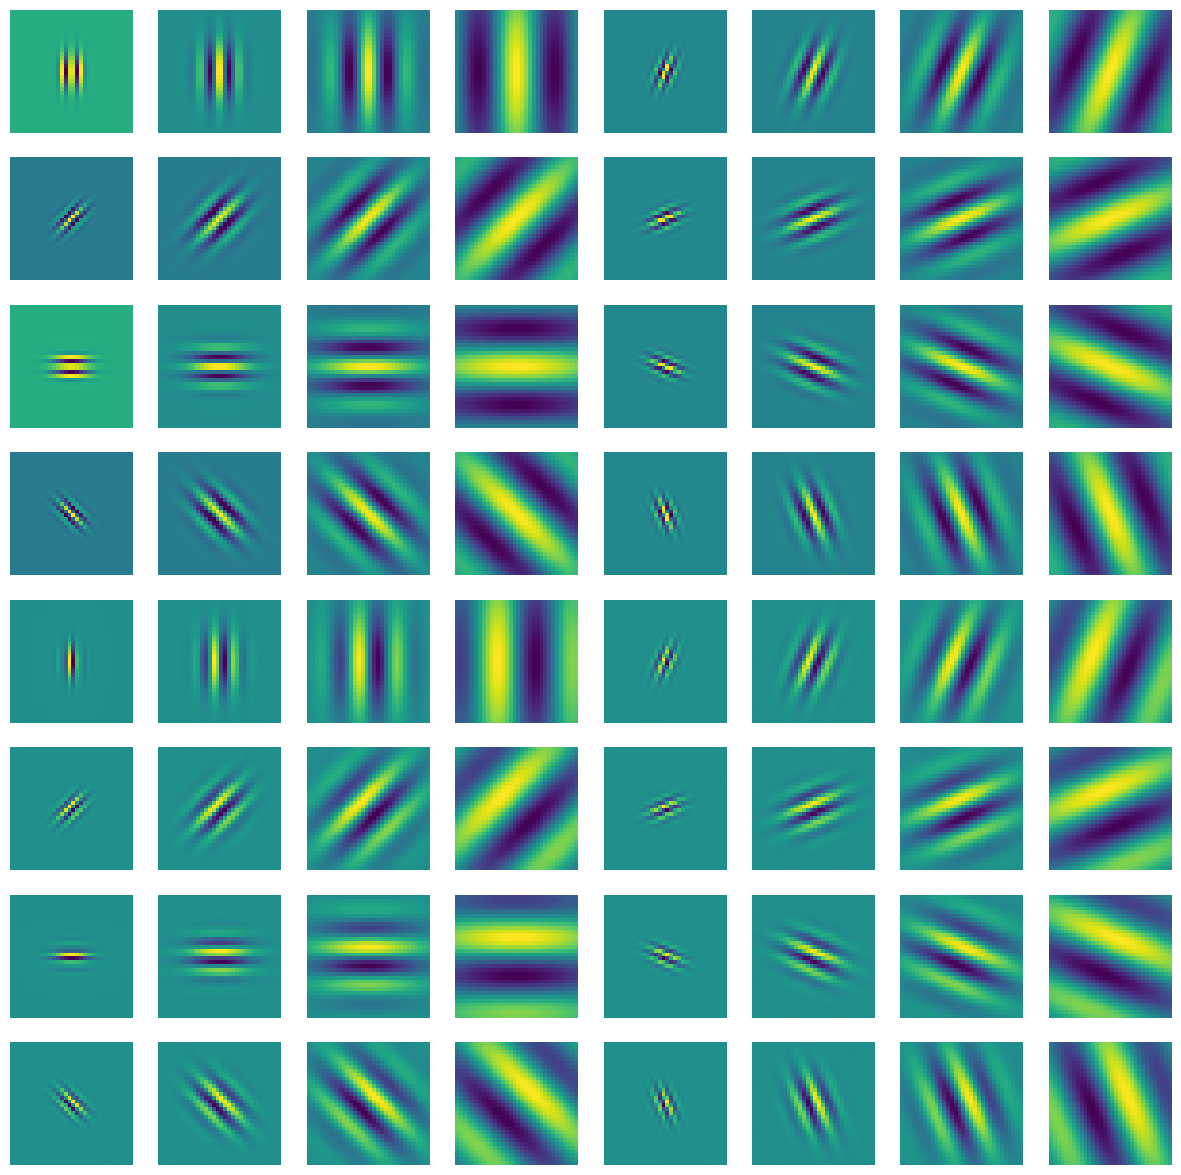

In [150]:
fig, axes = plt.subplots(8,8, figsize=(15,15))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(kernel[:,:,0,i])
    ax.axis("off")
plt.show()

Instantiate the checkpointer to reload the already trained model:

In [103]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(state)

In [104]:
state = orbax_checkpointer.restore(f"{prev_run.dir}/model-best", item=state)

In [105]:
param_count = sum(x.size for x in jax.tree_util.tree_leaves(state.params))
param_count

724

## Forward pass of the generated stimuli

In [ ]:
from functools import partial

In [ ]:
@jax.jit
def forward(state, inputs):
    return state.apply_fn({"params": state.params, **state.state}, inputs, train=False)

In [ ]:
@jax.jit
def forward_intermediates(state, inputs):
    return state.apply_fn({"params": state.params, **state.state}, inputs, train=False, capture_intermediates=True)

In [ ]:
kk = jnp.repeat(k[None,:,:,None], repeats=3, axis=-1)
kk.shape

(1, 384, 512, 3)

In [ ]:
%%time
outputs, extras = forward_intermediates(state, kk)
outputs.shape

CPU times: user 1min 10s, sys: 554 ms, total: 1min 11s
Wall time: 14.4 s


(1, 96, 128, 192)

## Checking the weights

In [ ]:
state.params.keys()

frozen_dict_keys(['CSFFourier_0', 'GDNGaussianStarRunning_0', 'GDNGaussianStarRunning_1', 'GDNGaussianStarRunning_2', 'GDNSpatioFreqOrient_0', 'GDNSpatioFreqOrient_1', 'GDNSpatioFreqOrient_2', 'GDNStarDisplacement_0', 'GDNStarDisplacement_1', 'GDNStarSign_0', 'GDNStarSign_1', 'GaborLayerLogSigma__0', 'GaborLayerLogSigma__1', 'GaborLayerLogSigma__2'])

### Gamma Correction

In [ ]:
layer_name = "GDNStarSign_0"
state.params[layer_name]

FrozenDict({
    Conv_0: {
        bias: array([0.30331576, 0.27588058, 0.19194828], dtype=float32),
        kernel: array([[[[0.04628028, 0.15649927, 0.5854984 ]]]], dtype=float32),
    },
})

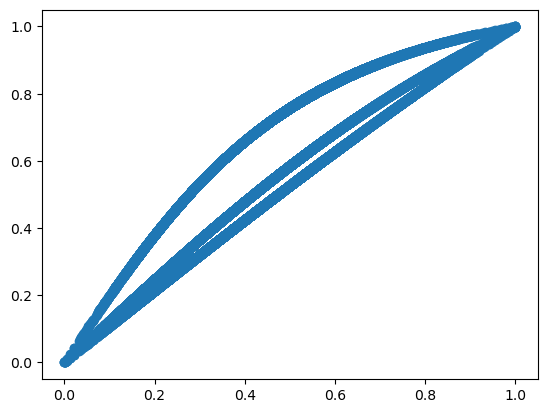

In [ ]:
plt.scatter(kk.ravel(),
            extras["intermediates"][layer_name]["__call__"][0].ravel())
plt.show()

### J & H

In [ ]:
prev_layer = "GDNStarSign_0"
layer_name = "JamesonHurvich_0"

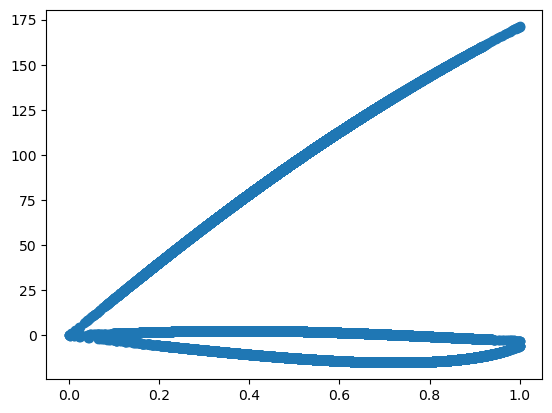

In [ ]:
plt.scatter(extras["intermediates"][prev_layer]["__call__"][0].ravel(),
            extras["intermediates"][layer_name]["__call__"][0].ravel())
plt.show()

### DN - A

In [ ]:
prev_layer = "JamesonHurvich_0"
layer_name = "GDNStarSign_1"
state.params[layer_name]

FrozenDict({
    Conv_0: {
        bias: array([901.4728], dtype=float32),
        kernel: array([[[[0.]]]], dtype=float32),
    },
})

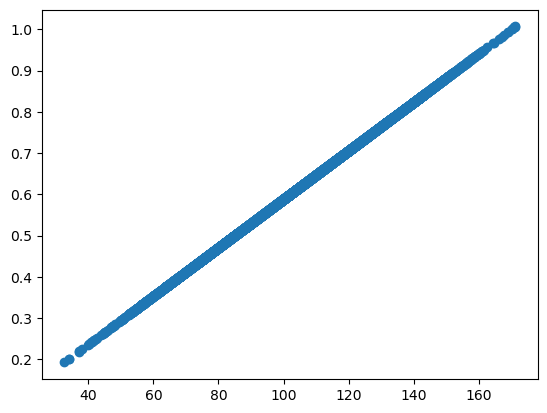

In [ ]:
plt.scatter(nn.max_pool(extras["intermediates"][prev_layer]["__call__"][0], window_shape=(2,2), strides=(2,2))[:,:,:,0].ravel(),
            extras["intermediates"][layer_name]["__call__"][0].ravel())
plt.show()

### DN - T

In [ ]:
prev_layer = "JamesonHurvich_0"
layer_name = "GDNStarDisplacement_0"
state.params[layer_name]

FrozenDict({
    Conv_0: {
        bias: array([100.4287], dtype=float32),
        kernel: array([[[[0.]]]], dtype=float32),
    },
})

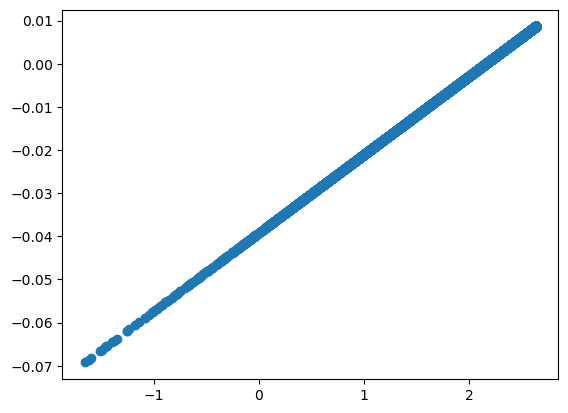

In [ ]:
plt.scatter(nn.max_pool(extras["intermediates"][prev_layer]["__call__"][0], window_shape=(2,2), strides=(2,2))[:,:,:,1].ravel(),
            extras["intermediates"][layer_name]["__call__"][0].ravel())
plt.show()

### DN - D

In [ ]:
prev_layer = "JamesonHurvich_0"
layer_name = "GDNStarDisplacement_1"
state.params[layer_name]

FrozenDict({
    Conv_0: {
        bias: array([98.00084], dtype=float32),
        kernel: array([[[[1.7282574]]]], dtype=float32),
    },
})

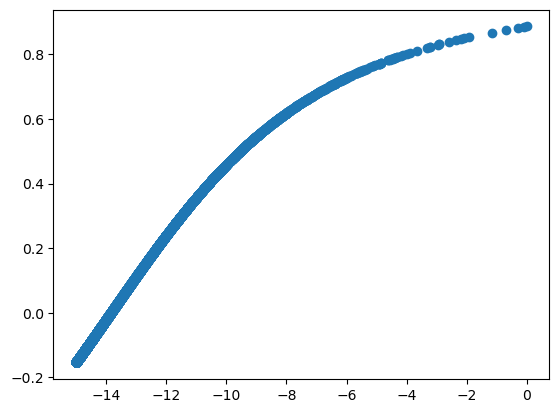

In [ ]:
plt.scatter(nn.max_pool(extras["intermediates"][prev_layer]["__call__"][0], window_shape=(2,2), strides=(2,2))[:,:,:,2].ravel(),
            extras["intermediates"][layer_name]["__call__"][0].ravel())
plt.show()

### CSF

In [ ]:
prev_layer = "GDNStarSign_1"
layer_name = "CSFFourier_0"
state.params[layer_name]

FrozenDict({
    alpha_achrom: array(1., dtype=float32),
    alpha_chrom_rg: array(1., dtype=float32),
    alpha_chrom_yb: array(1., dtype=float32),
    beta_achrom: array(1.1093283, dtype=float32),
    beta_chrom: array(0.45348847, dtype=float32),
    fm: array(4.3306127, dtype=float32),
    s: array(4.350155, dtype=float32),
})

In [ ]:
csf_sso, fx, fy = CSFFourier.csf_sso(fs=64, Nx=512//2, Ny=384//2, alpha=state.params["CSFFourier_0"]["alpha_achrom"],
                   beta=state.params["CSFFourier_0"]["beta_achrom"], g=330.74, fm=state.params["CSFFourier_0"]["fm"], 
                    l=0.837, s=state.params["CSFFourier_0"]["s"], w=1.0, os=6.664)

In [ ]:
csf_chrom_rg, csf_chrom_yb, fx, fy = CSFFourier.csf_chrom(fs=64, Nx=512//2, Ny=384//2, alpha_rg=state.params["CSFFourier_0"]["alpha_chrom_rg"],
                   alpha_yb=state.params["CSFFourier_0"]["alpha_chrom_yb"],
                   beta=state.params["CSFFourier_0"]["beta_chrom"])

In [ ]:
def scale_csf(csf_a, csf_rg, csf_yb):
    csfs = jnp.stack([csf_a, csf_rg, csf_yb], axis=-1)
    E1 = jnp.sum(jnp.ones_like(csfs)**2)#**(1/2)
    E_CSF = jnp.sum(csfs**2)#**(1/2)
    csfs = (csfs/E_CSF)*E1
    return csfs[:,:,0], csfs[:,:,1], csfs[:,:,2], csfs.min(), csfs.max()

In [ ]:
csf_sso, csf_chrom_rg, csf_chrom_yb, m, M = scale_csf(csf_sso, csf_chrom_rg, csf_chrom_yb)
# csfs = scale_csf(csf_sso, csf_chrom_rg, csf_chrom_yb)

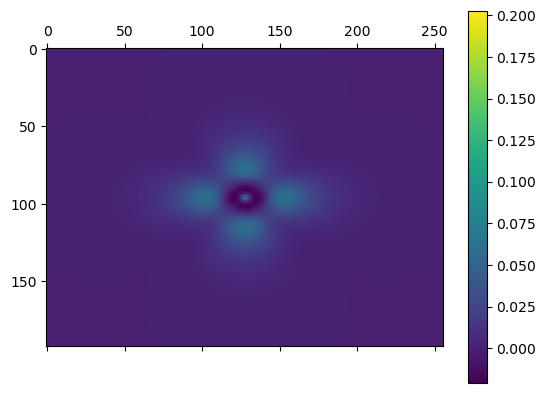

In [ ]:
plt.matshow(csf_sso, vmin=m, vmax=M)
plt.colorbar()
plt.show()

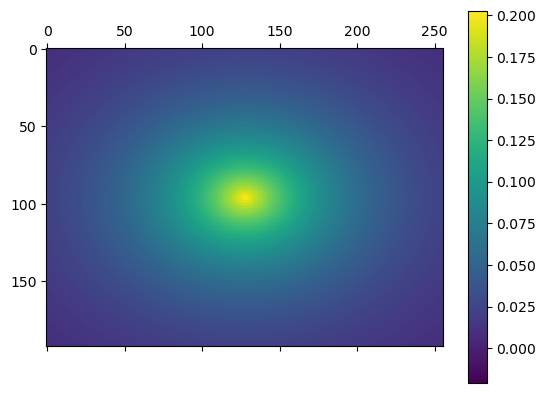

In [ ]:
plt.matshow(csf_chrom_rg, vmin=m, vmax=M)
plt.colorbar()
plt.show()

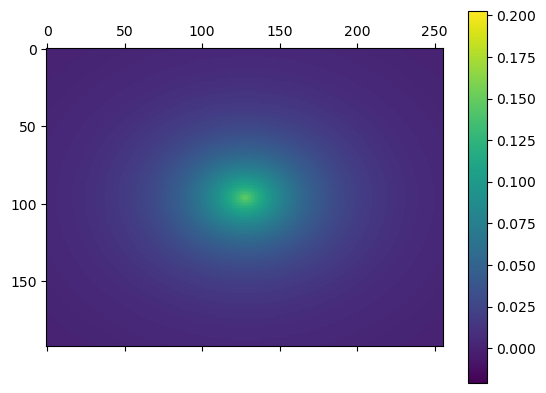

In [ ]:
plt.matshow(csf_chrom_yb, vmin=m, vmax=M)
plt.colorbar()
plt.show()

### DN Gaussian - A

In [ ]:
prev_layer = "CSFFourier_0"
layer_name = "GDNGaussianStarRunning_0"
state.params[layer_name]

FrozenDict({
    GaussianLayerGamma_0: {
        A: array([1.], dtype=float32),
        bias: array([3.6030602], dtype=float32),
        gamma: array([29.267475], dtype=float32),
    },
})

In [ ]:
1/state.params[layer_name]["GaussianLayerGamma_0"]["gamma"]

array([0.03416762], dtype=float32)

In [ ]:
state.state["batch_stats"][layer_name]

FrozenDict({
    inputs_star: array([0.18572384], dtype=float32),
})

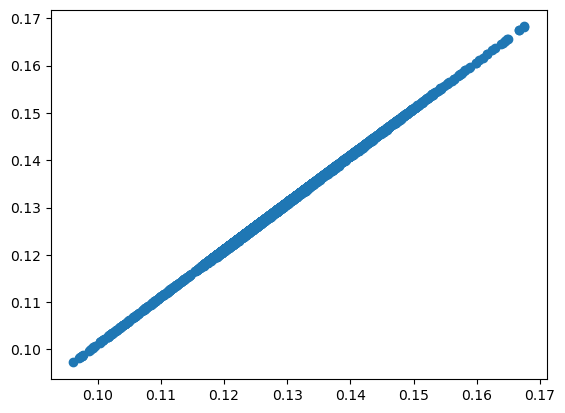

In [ ]:
plt.scatter(nn.max_pool(extras["intermediates"][prev_layer]["__call__"][0], window_shape=(2,2), strides=(2,2))[:,:,:,0].ravel(),
            extras["intermediates"][layer_name]["__call__"][0].ravel())
plt.show()

### DN Gaussian - T

In [ ]:
prev_layer = "CSFFourier_0"
layer_name = "GDNGaussianStarRunning_1"
state.params[layer_name]

FrozenDict({
    GaussianLayerGamma_0: {
        A: array([1.], dtype=float32),
        bias: array([0.19330175], dtype=float32),
        gamma: array([30.321594], dtype=float32),
    },
})

In [ ]:
1/state.params[layer_name]["GaussianLayerGamma_0"]["gamma"]

array([0.0329798], dtype=float32)

In [ ]:
state.state["batch_stats"][layer_name]

FrozenDict({
    inputs_star: array([0.02049169], dtype=float32),
})

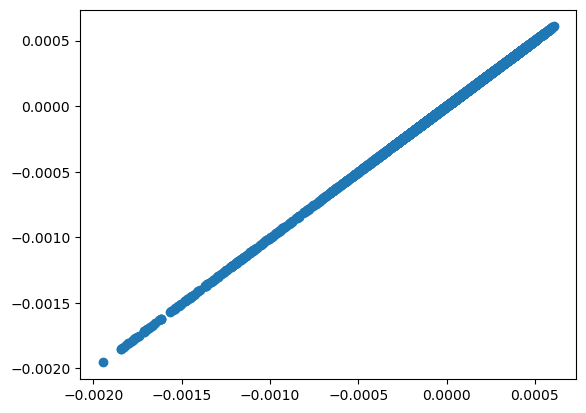

In [ ]:
plt.scatter(nn.max_pool(extras["intermediates"][prev_layer]["__call__"][0], window_shape=(2,2), strides=(2,2))[:,:,:,1].ravel(),
            extras["intermediates"][layer_name]["__call__"][0].ravel())
plt.show()

### DN Gaussian - D

In [ ]:
prev_layer = "CSFFourier_0"
layer_name = "GDNGaussianStarRunning_2"
state.params[layer_name]

FrozenDict({
    GaussianLayerGamma_0: {
        A: array([1.], dtype=float32),
        bias: array([0.32192546], dtype=float32),
        gamma: array([25.486809], dtype=float32),
    },
})

In [ ]:
1/state.params[layer_name]["GaussianLayerGamma_0"]["gamma"]

array([0.03923598], dtype=float32)

In [ ]:
state.state["batch_stats"][layer_name]

FrozenDict({
    inputs_star: array([0.01822207], dtype=float32),
})

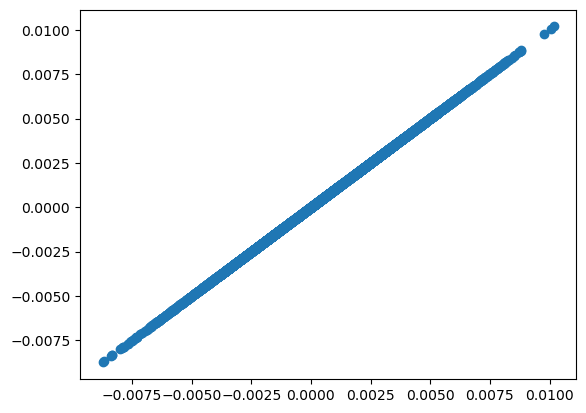

In [ ]:
plt.scatter(nn.max_pool(extras["intermediates"][prev_layer]["__call__"][0], window_shape=(2,2), strides=(2,2))[:,:,:,2].ravel(),
            extras["intermediates"][layer_name]["__call__"][0].ravel())
plt.show()

### Gabor - A

In [106]:
prev_layer = "CSFFourier_0"
layer_name = "GaborLayerLogSigma__0"
state.params[layer_name]

FrozenDict({
    freq: array([15.95043 , 11.23141 ,  8.208757,  3.444948], dtype=float32),
    logsigmax2: array([-6.6602883, -4.145869 , -4.16324  , -4.2376814], dtype=float32),
    logsigmay2: array([-3.2284849, -3.5562255, -3.8001058, -3.9148755], dtype=float32),
    sigma_theta: array([-0.58955544, -0.89970714, -1.669148  ,  2.1901314 ,  2.7797666 ,
            1.3890419 ,  3.7836094 ,  3.819307  ], dtype=float32),
    theta: array([0.66961366, 0.811226  , 1.6005925 , 0.82882184, 0.61903197,
           2.093932  , 2.466555  , 2.4245949 ], dtype=float32),
})

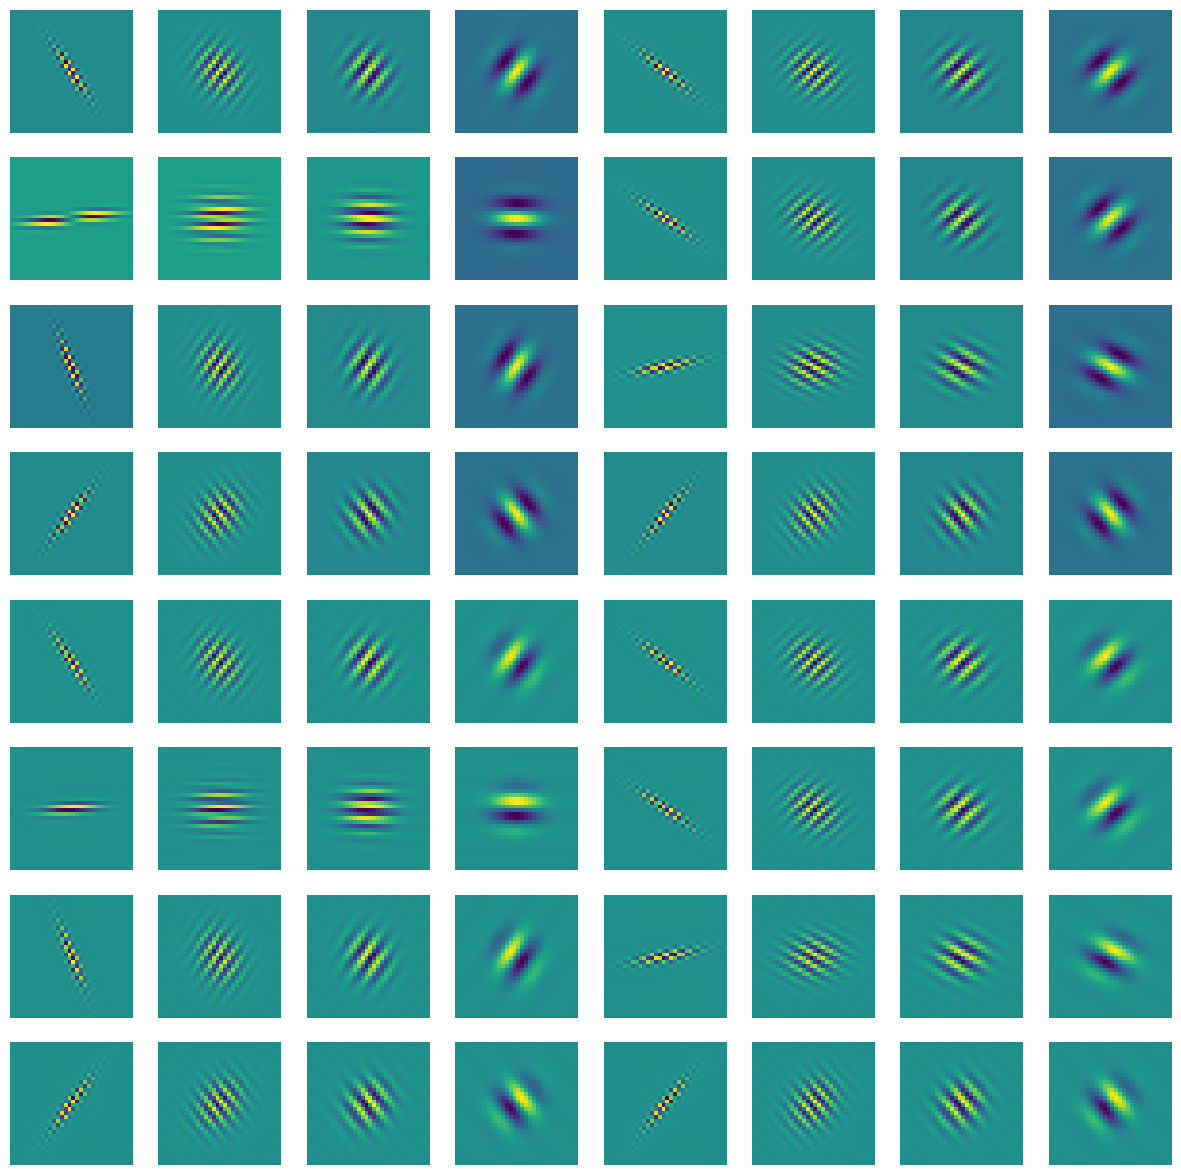

In [107]:
fig, axes = plt.subplots(8,8, figsize=(15,15))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(state.state["precalc_filter"][layer_name]["kernel"][:,:,0,i])
    ax.axis("off")
plt.show()

In [108]:
kernel = state.state["precalc_filter"][layer_name]["kernel"]
kernel.shape

(32, 32, 1, 64)

In [117]:
kernel_f_fft = jnp.fft.fftn(kernel[:,:,0,:], axes=(0,1))
kernel_f_fft = jnp.fft.fftshift(kernel_f_fft)
kernel_f_fft_abs_sum = jnp.abs(kernel_f_fft).sum(axis=-1)
kernel_f_fft.shape, kernel_f_fft_abs_sum.shape

((32, 32, 64), (32, 32))

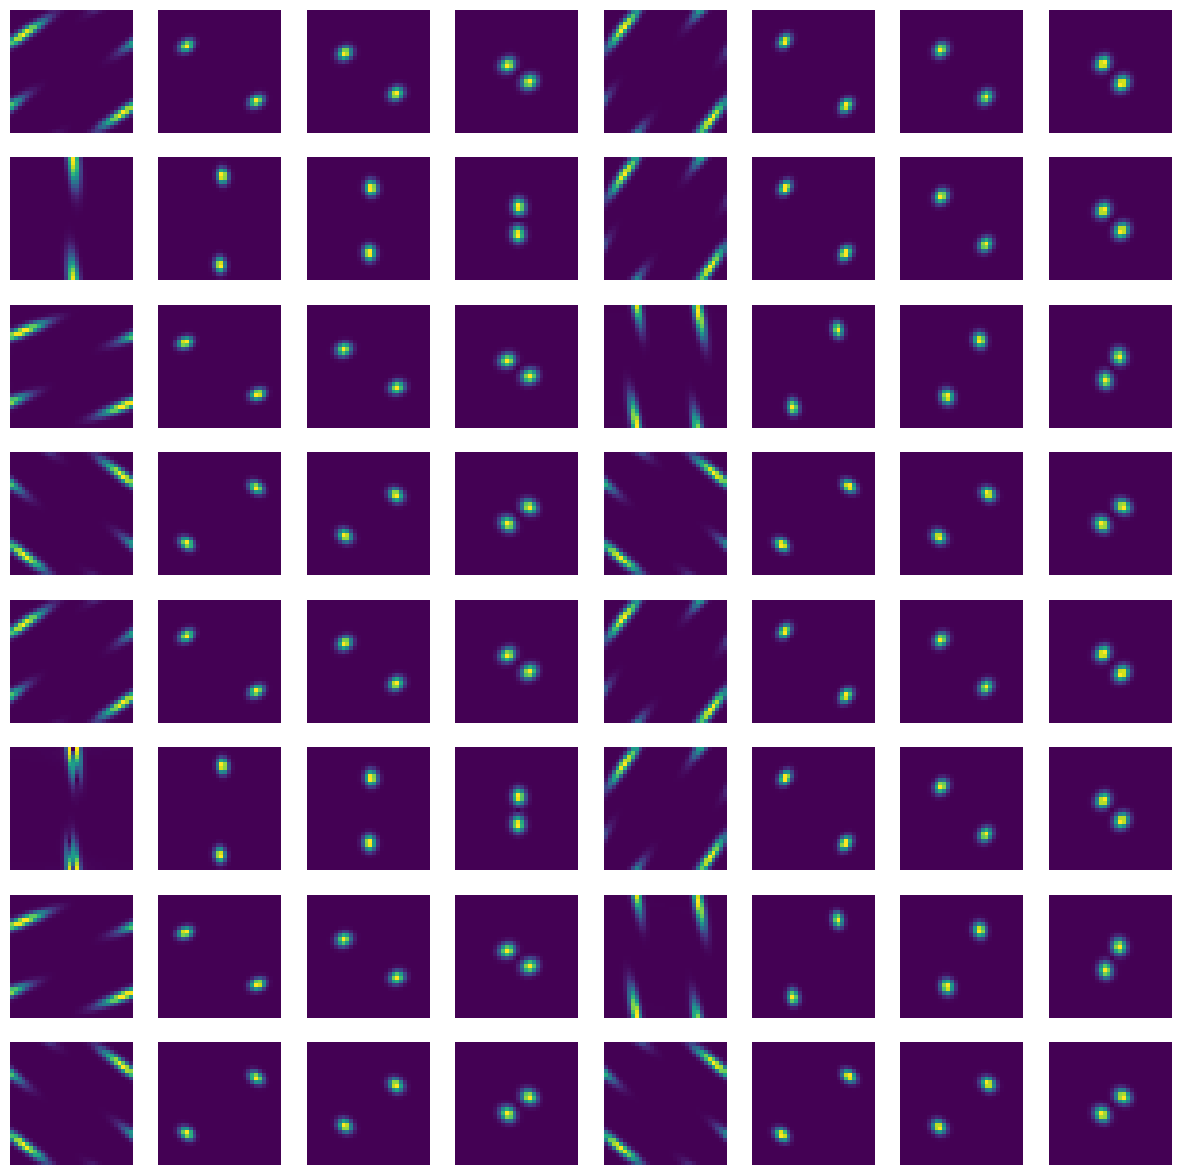

In [115]:
fig, axes = plt.subplots(8,8, figsize=(15,15))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(jnp.abs(kernel_f_fft[:,:,i]))
    ax.axis("off")
plt.show()

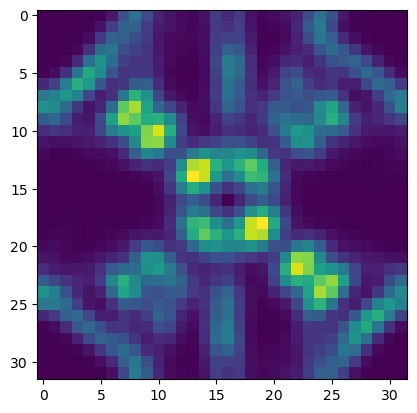

In [118]:
plt.imshow(kernel_f_fft_abs_sum)
plt.show()

### Gabor - T

In [120]:
prev_layer = "CSFFourier_0"
layer_name = "GaborLayerLogSigma__1"
state.params[layer_name]

FrozenDict({
    freq: array([14.405295,  9.416919,  6.030612,  6.037985], dtype=float32),
    logsigmax2: array([-2.2185998 ,  0.31817645, -3.4176817 , -3.4481425 ], dtype=float32),
    logsigmay2: array([ 2.85815   ,  1.4713516 ,  0.08437492, -0.09802637], dtype=float32),
    sigma_theta: array([-1.0708815 , -1.0739669 ,  2.0716183 ,  2.0686457 ,  2.0723345 ,
            0.40639338,  3.5469496 ,  3.5463285 ], dtype=float32),
    theta: array([1.2323861, 1.2319632, 1.2332304, 1.2326027, 1.23359  , 2.3042793,
           2.305485 , 2.304636 ], dtype=float32),
})

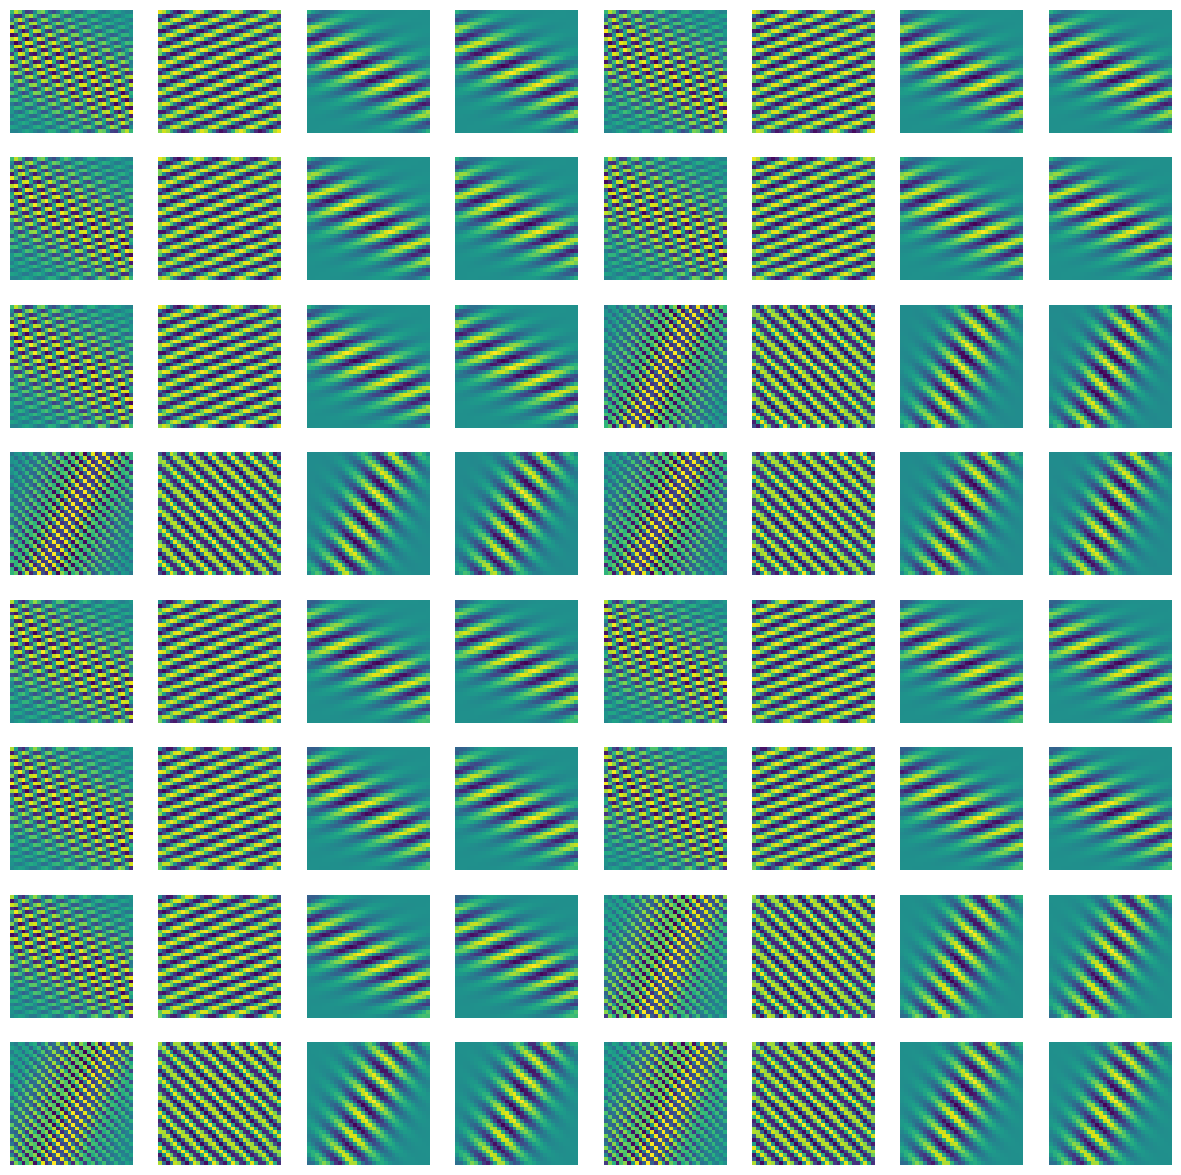

In [121]:
fig, axes = plt.subplots(8,8, figsize=(15,15))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(state.state["precalc_filter"][layer_name]["kernel"][:,:,0,i])
    ax.axis("off")
plt.show()

In [122]:
kernel = state.state["precalc_filter"][layer_name]["kernel"]
kernel.shape

(32, 32, 1, 64)

In [123]:
kernel_f_fft = jnp.fft.fftn(kernel[:,:,0,:], axes=(0,1))
kernel_f_fft = jnp.fft.fftshift(kernel_f_fft)
kernel_f_fft_abs_sum = jnp.abs(kernel_f_fft).sum(axis=-1)
kernel_f_fft.shape, kernel_f_fft_abs_sum.shape

((32, 32, 64), (32, 32))

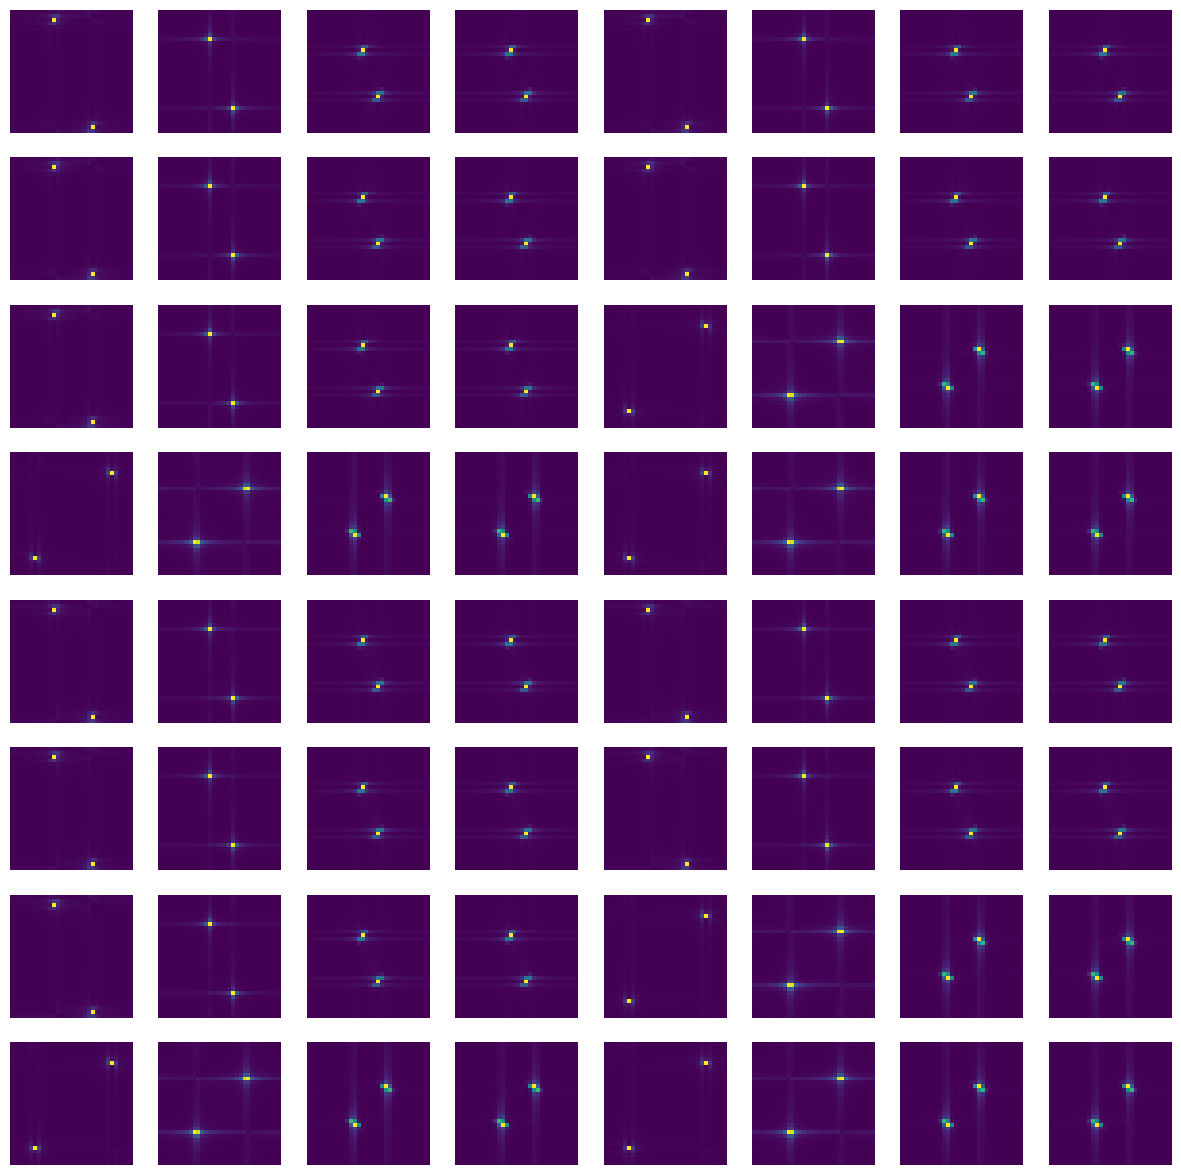

In [124]:
fig, axes = plt.subplots(8,8, figsize=(15,15))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(jnp.abs(kernel_f_fft[:,:,i]))
    ax.axis("off")
plt.show()

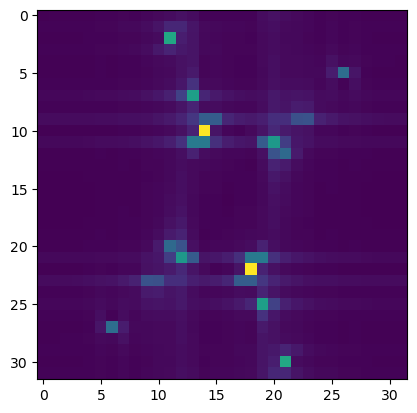

In [125]:
plt.imshow(kernel_f_fft_abs_sum)
plt.show()

### Gabor - D

In [111]:
prev_layer = "CSFFourier_0"
layer_name = "GaborLayerLogSigma__2"
state.params[layer_name]

FrozenDict({
    freq: array([9.540185, 6.177744, 4.235544, 4.233737], dtype=float32),
    logsigmax2: array([-7.898701 , -4.67623  , -1.4527982, -1.5389379], dtype=float32),
    logsigmay2: array([-2.210218 , -1.8376193, -1.9250672, -1.978017 ], dtype=float32),
    sigma_theta: array([0.03715657, 0.04404304, 0.0758374 , 0.22487386, 2.6455462 ,
           1.5212849 , 1.5327374 , 3.6739066 ], dtype=float32),
    theta: array([1.0787677, 1.0911318, 1.1234345, 1.126832 , 1.3605336, 2.4776978,
           2.49017  , 2.4856021], dtype=float32),
})

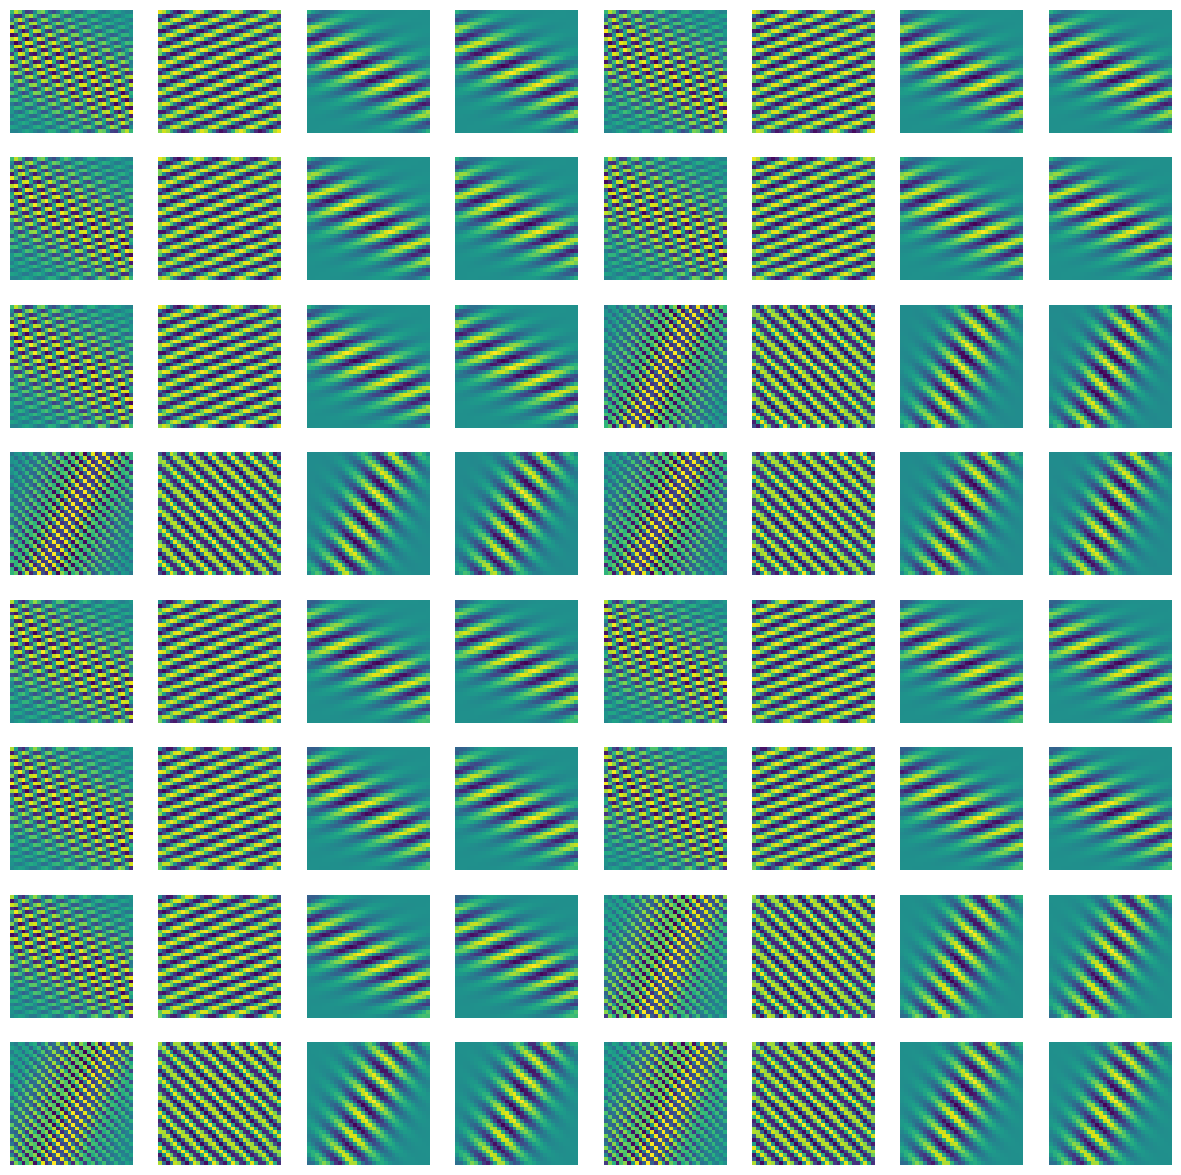

In [130]:
fig, axes = plt.subplots(8,8, figsize=(15,15))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(state.state["precalc_filter"][layer_name]["kernel"][:,:,0,i])
    ax.axis("off")
plt.show()

In [131]:
kernel = state.state["precalc_filter"][layer_name]["kernel"]
kernel.shape

(32, 32, 1, 64)

In [132]:
kernel_f_fft = jnp.fft.fftn(kernel[:,:,0,:], axes=(0,1))
kernel_f_fft = jnp.fft.fftshift(kernel_f_fft)
kernel_f_fft_abs_sum = jnp.abs(kernel_f_fft).sum(axis=-1)
kernel_f_fft.shape, kernel_f_fft_abs_sum.shape

((32, 32, 64), (32, 32))

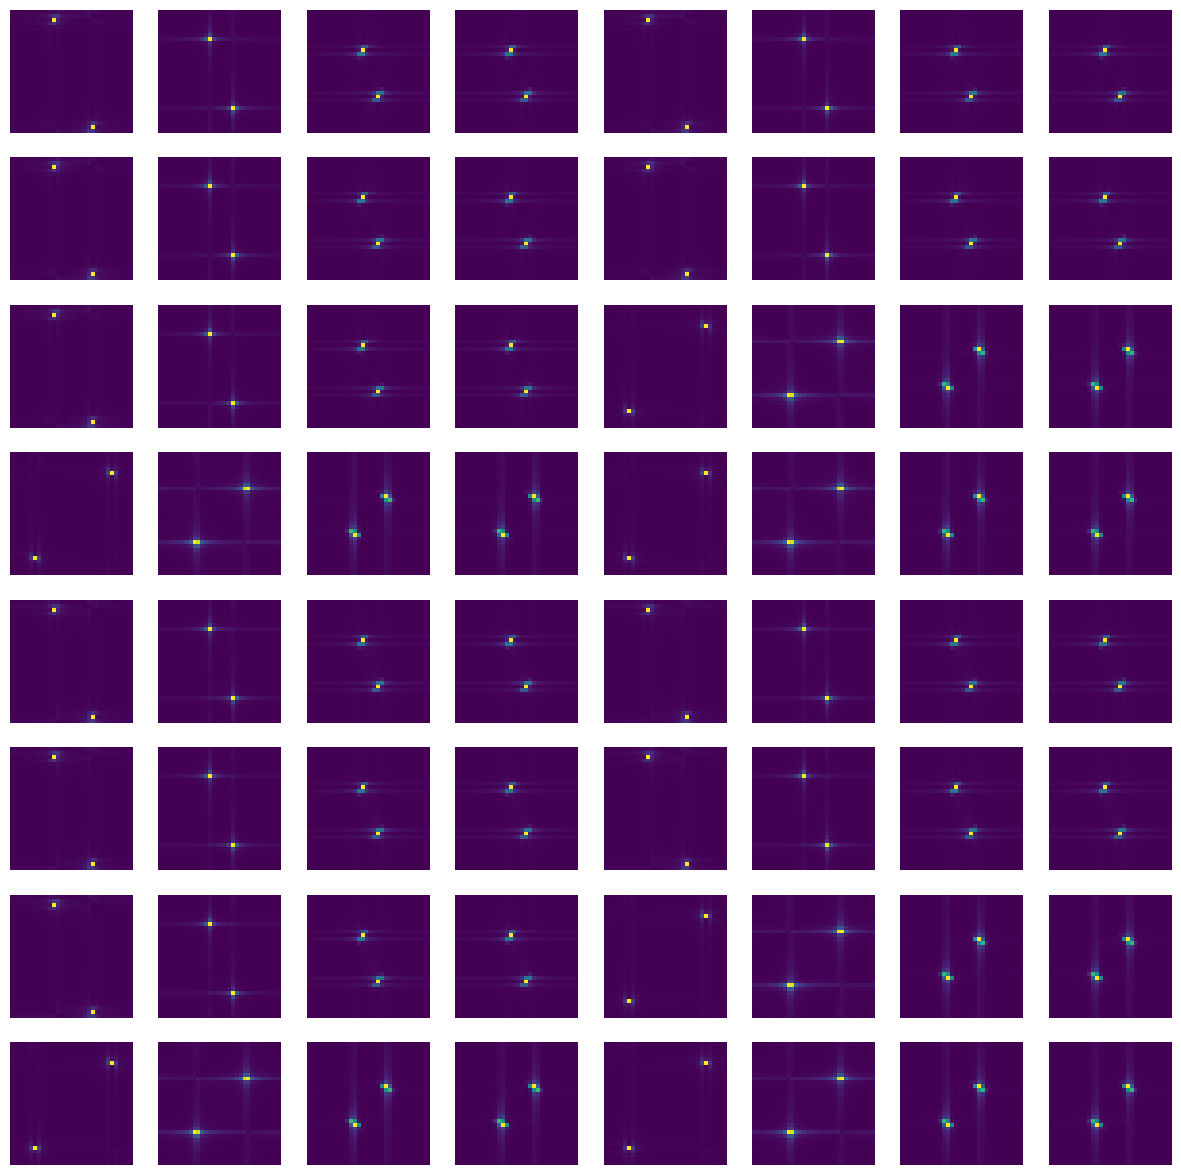

In [133]:
fig, axes = plt.subplots(8,8, figsize=(15,15))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(jnp.abs(kernel_f_fft[:,:,i]))
    ax.axis("off")
plt.show()

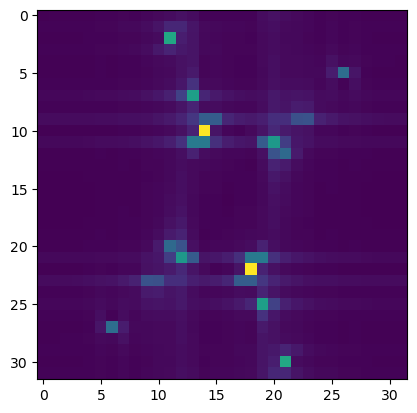

In [134]:
plt.imshow(kernel_f_fft_abs_sum)
plt.show()

### DN SpatioFreqOrient - A

In [135]:
prev_layer = "GaborLayerLogSigma__0"
layer_name = "GDNSpatioFreqOrient_0"
state.params[layer_name]["FreqGaussian_0"]

FrozenDict({
    sigma: array([ 0.4630381 ,  0.26121604,  0.5362097 , 11.280371  ], dtype=float32),
})

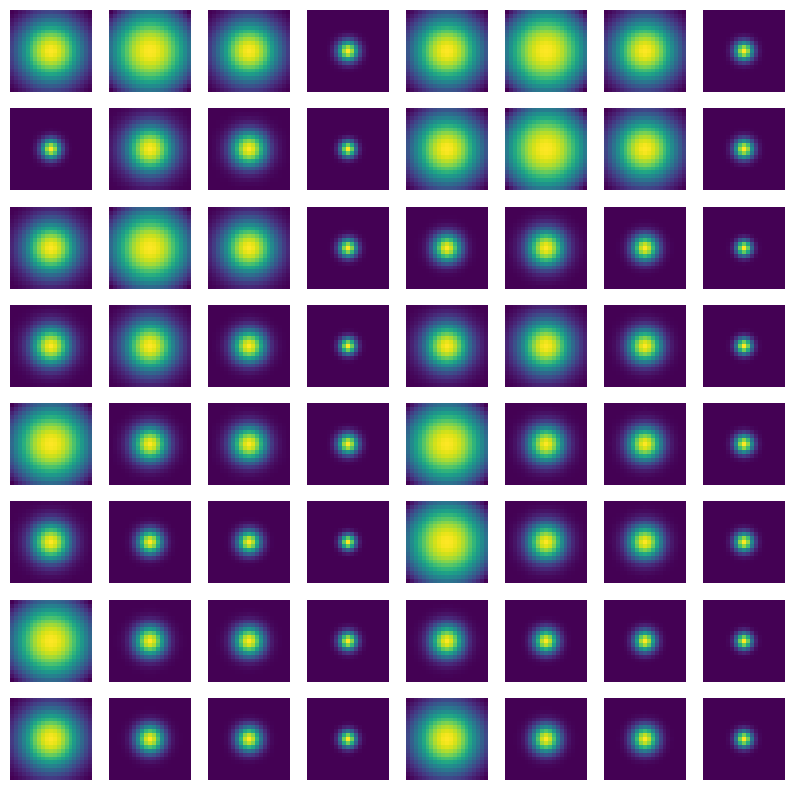

In [173]:
fig, axes = plt.subplots(8,8, figsize=(10,10))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(state.state["precalc_filter"]["GDNSpatioFreqOrient_0"]["GaussianLayerGamma_0"]["kernel"][:,:,0,i])
    ax.axis("off")
plt.show()

Things to note:
- Frequency sigma got a lot bigger for smaller frequencies.
- Spatial Gaussians are diverse: not all of them want to get as big as possible.
- Not training A leads to better behavior overall.

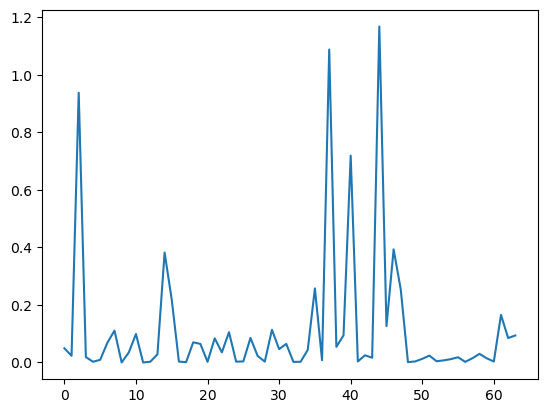

In [136]:
plt.plot(state.params[layer_name]["bias"])
plt.show()

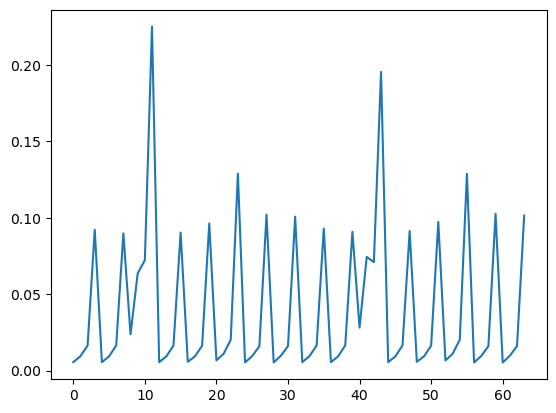

In [137]:
plt.plot(state.state["batch_stats"][layer_name]["inputs_star"])
plt.show()

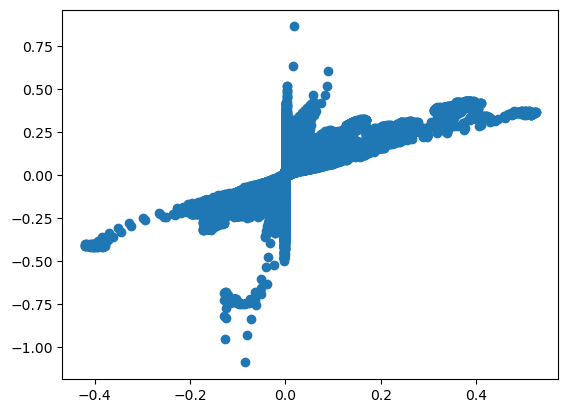

In [134]:
plt.scatter(extras["intermediates"][prev_layer]["__call__"][0][0].ravel(),
            extras["intermediates"][layer_name]["__call__"][0].ravel())
plt.show()

### DN SpatioFreqOrient - T

In [138]:
prev_layer = "GaborLayerLogSigma__1"
layer_name = "GDNSpatioFreqOrient_1"
state.params[layer_name]["FreqGaussian_0"]

FrozenDict({
    sigma: array([6.5152745, 4.066233 , 2.6751943, 2.9600997], dtype=float32),
})

Higher frequencies have higher interaction with other frequencies than lower frequencies.

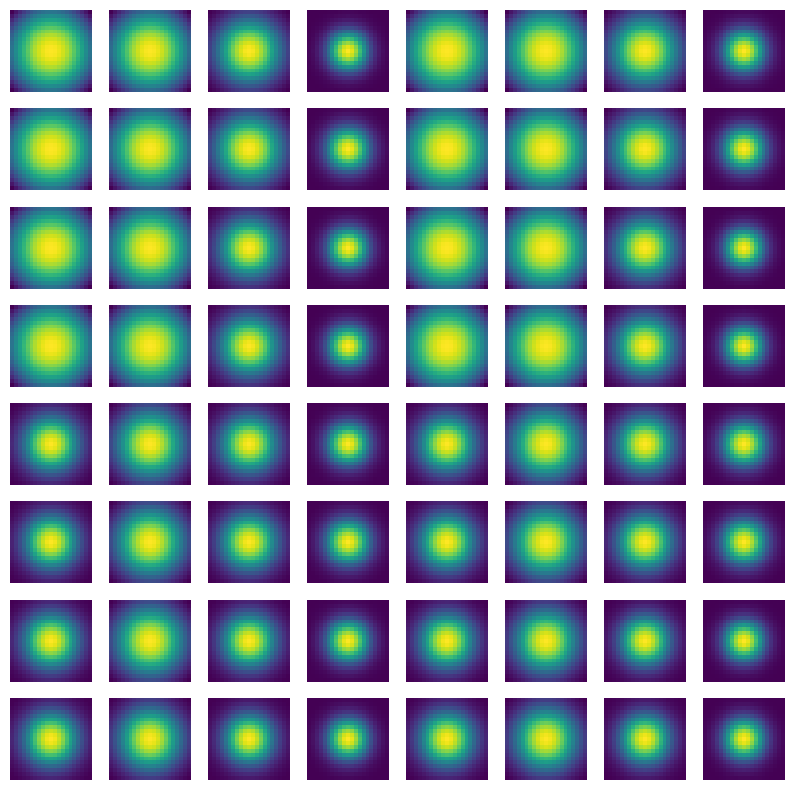

In [140]:
fig, axes = plt.subplots(8,8, figsize=(10,10))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(state.state["precalc_filter"][layer_name]["GaussianLayerGamma_0"]["kernel"][:,:,0,i])
    ax.axis("off")
plt.show()

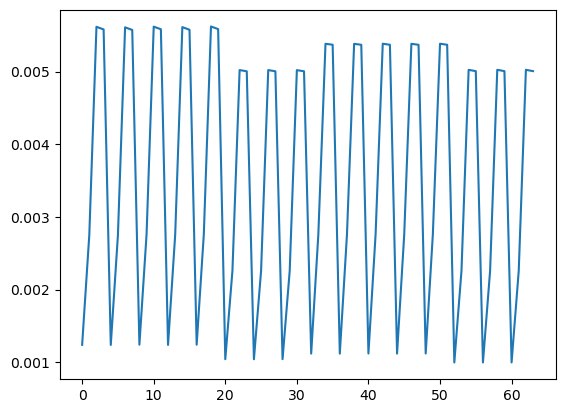

In [141]:
plt.plot(state.state["batch_stats"][layer_name]["inputs_star"])
plt.show()

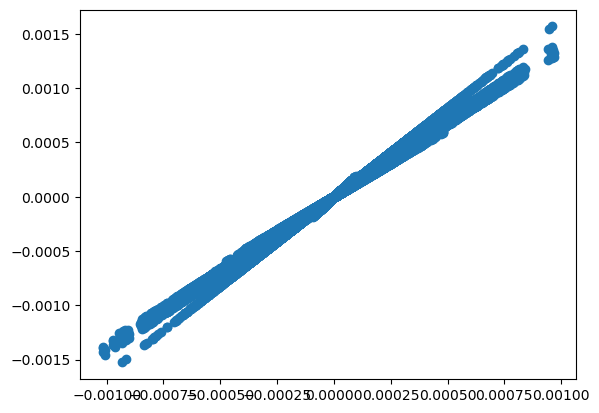

In [137]:
plt.scatter(extras["intermediates"][prev_layer]["__call__"][0][0].ravel(),
            extras["intermediates"][layer_name]["__call__"][0].ravel())
plt.show()

### DN SpatioFreqOrient - D

In [142]:
prev_layer = "GaborLayerLogSigma__2"
layer_name = "GDNSpatioFreqOrient_2"
state.params[layer_name]["FreqGaussian_0"]

FrozenDict({
    sigma: array([8.3922589e-01, 3.9584076e-01, 2.8330515e-04, 2.7623866e-04],
          dtype=float32),
})

In [144]:
state.params[layer_name]["OrientGaussian_0"]

FrozenDict({
    sigma: array([19.365   , 19.17711 , 15.178944, 15.868834, 17.16133 , 16.9975  ,
           18.424845, 18.870304], dtype=float32),
})

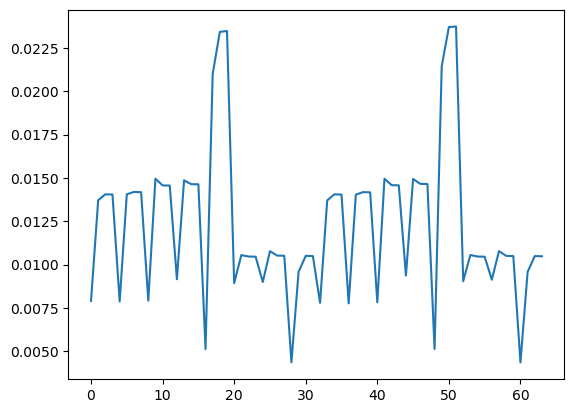

In [145]:
plt.plot(state.state["batch_stats"][layer_name]["inputs_star"])
plt.show()

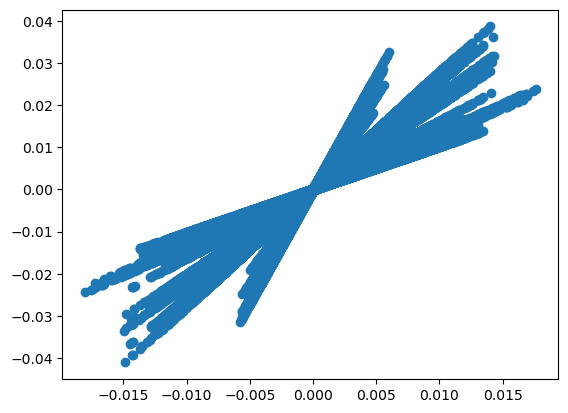

In [140]:
plt.scatter(extras["intermediates"][prev_layer]["__call__"][0][0].ravel(),
            extras["intermediates"][layer_name]["__call__"][0].ravel())
plt.show()

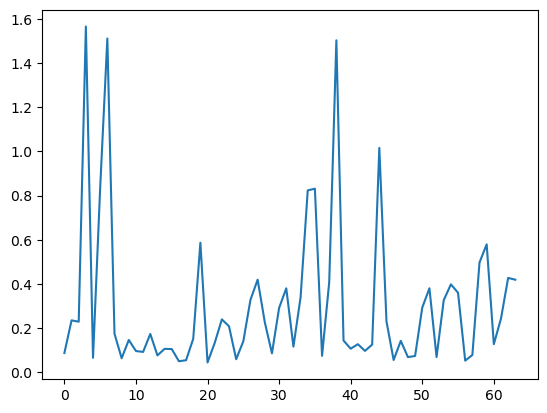

In [141]:
plt.plot(state.params[layer_name]["bias"])

In [142]:
state.state["batch_stats"][layer_name]

FrozenDict({
    inputs_star: array([0.0079037 , 0.0137171 , 0.01405553, 0.01404496, 0.00787011,
           0.01405877, 0.01419089, 0.01417929, 0.00791802, 0.0149566 ,
           0.01456976, 0.01456135, 0.00915565, 0.01486161, 0.01464058,
           0.01463435, 0.00512455, 0.02100514, 0.0234293 , 0.0234759 ,
           0.00893083, 0.01054993, 0.01046724, 0.01045612, 0.00899676,
           0.01077323, 0.01052221, 0.01051136, 0.00436078, 0.00957928,
           0.01050628, 0.01049282, 0.00779851, 0.01370323, 0.01405381,
           0.01404111, 0.00776275, 0.01403727, 0.01418071, 0.01417086,
           0.00782659, 0.01495278, 0.01458297, 0.01457493, 0.00936886,
           0.01494052, 0.01465967, 0.01465066, 0.00513209, 0.02145081,
           0.02370256, 0.02373886, 0.00904621, 0.01055381, 0.01046705,
           0.01045565, 0.00912863, 0.01077784, 0.01050469, 0.01049417,
           0.00435332, 0.00957547, 0.01049268, 0.0104808 ], dtype=float32),
})

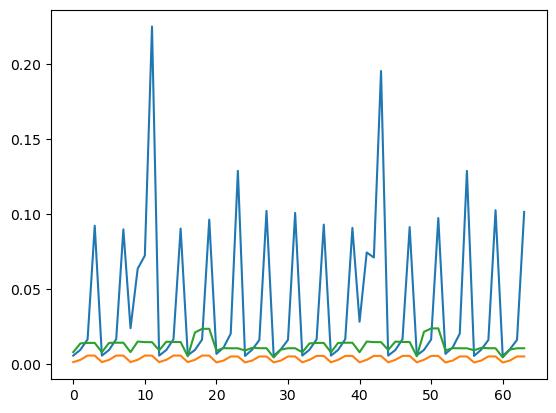

In [146]:
plt.plot(state.state["batch_stats"]["GDNSpatioFreqOrient_0"]["inputs_star"])
plt.plot(state.state["batch_stats"]["GDNSpatioFreqOrient_1"]["inputs_star"])
plt.plot(state.state["batch_stats"]["GDNSpatioFreqOrient_2"]["inputs_star"])

### Final output

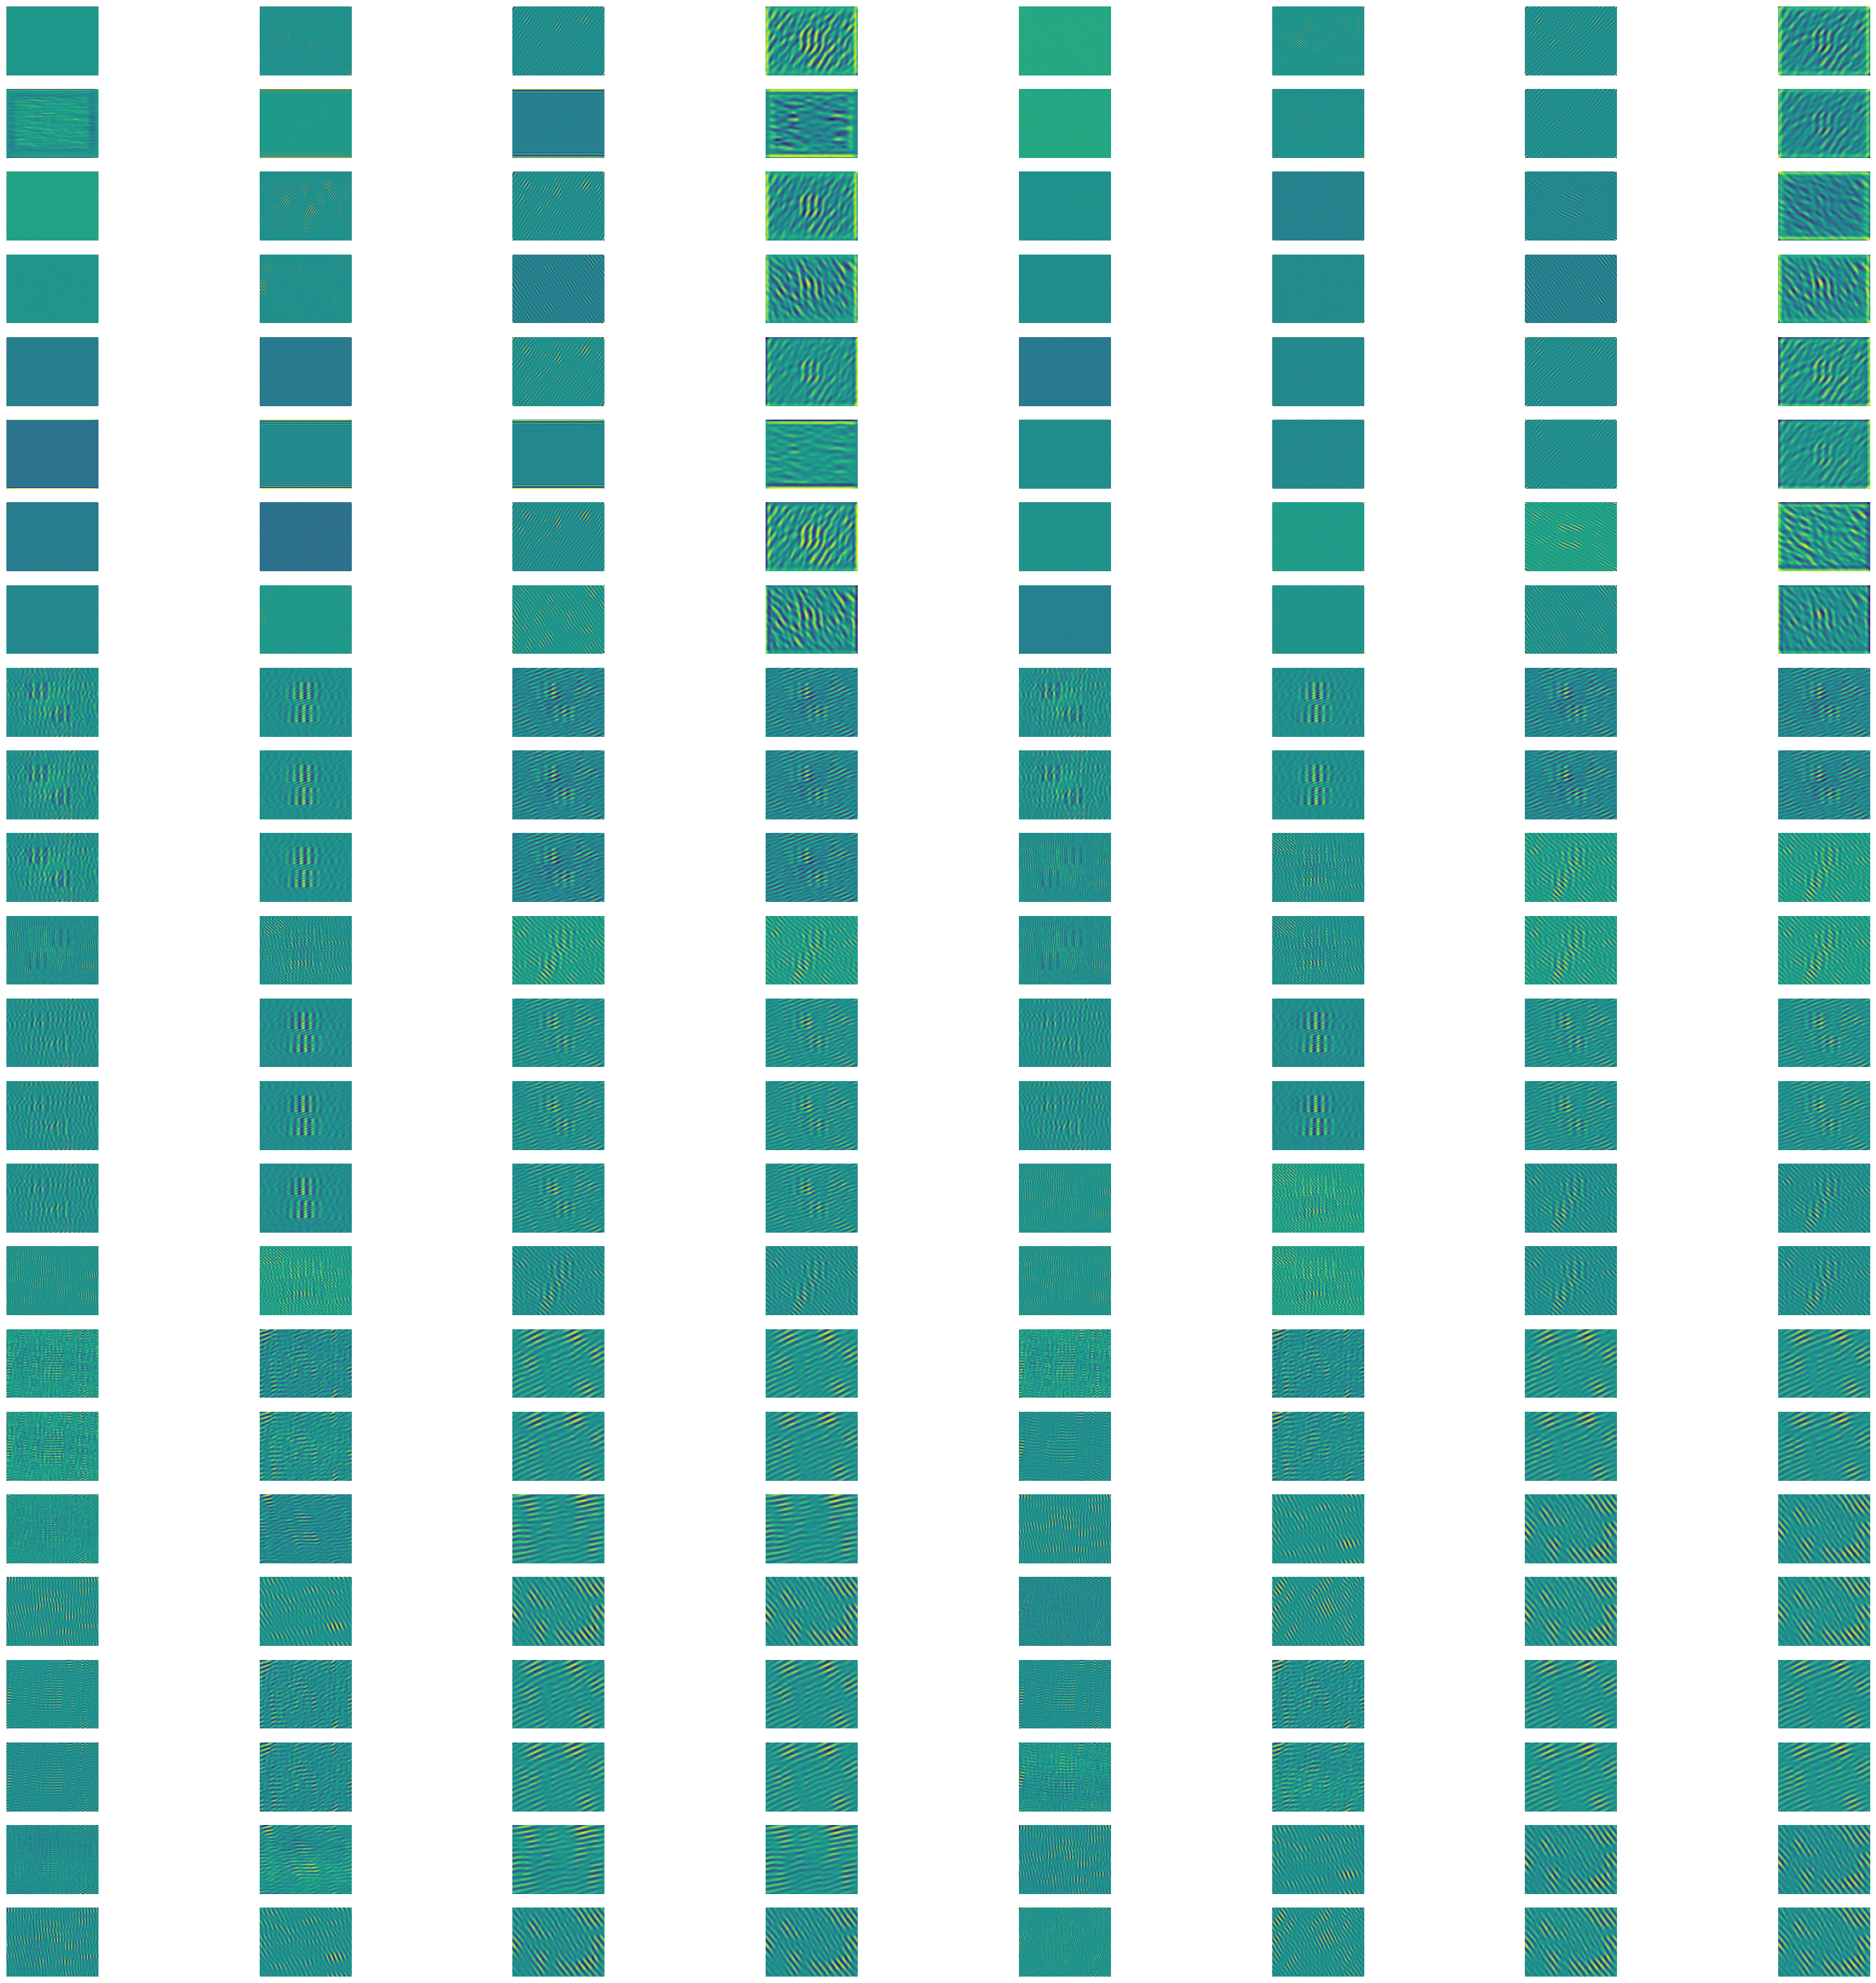

In [149]:
fig, axes = plt.subplots(8*3,8, figsize=(40,40))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(outputs[0,:,:,i])
    ax.axis("off")
plt.show()